In [7]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import parser

In [8]:
dfsber = parser.get_df("sber", local=True)
dfvtb = parser.get_df("vtbr", local=True)
dft = parser.get_df("tcsg", local=True)

In [9]:
qsber = pd.to_datetime(dfsber['TRADEDATE (date:10)'])
qvtb = pd.to_datetime(dfvtb['TRADEDATE (date:10)'])
qt = pd.to_datetime(dft['TRADEDATE (date:10)'])

Скорректируем метрики на акции банка ВТБ с учётом [обратного сплита](https://t-j.ru/news/review-vtbr-back-split) 5000:1. Цены скорректируем на новые.

In [10]:
mask = dfvtb['TRADEDATE (date:10)'] < '2024-07-15'
dfvtb.loc[mask, ["OPEN (double)", "LOW (double)", "HIGH (double)", "LEGALCLOSEPRICE (double)", "WAPRICE (double)", "CLOSE (double)", "MARKETPRICE2 (double)", "MARKETPRICE3 (double)"]] *= 5000
dfvtb.loc[mask, "VOLUME (double)"] /= 5000

In [11]:
spfr = [dfsber, dfvtb, dft]
spbn = ['Сбер', 'ВТБ', 'Т-Банк']

В таблице, спарсенной с сайта Мосбиржи, содержится информация о торгах акций различных банков на каждый день с 1 января 2020 года по 31 октября 2024 года, за исключением выходных и праздничных дней.

Что содержится в каждой из колонок таблицы?

0 колонка - индекс

1 колонка (BOARDID) - идентификатор рынка. У нас это TQBR - основной рынок акций на Мосбирже.

2 колонка (TRADEDATE) - дата торгов.

3 колонка (SHORTNAME) - имя компании 

4 колонка (SECID) - тикер банка

5 колонка (NUMTRADES) - количество сделок за день

6 колонка (VALUE) - денежный объем торгов (цена*количество; суммарная стоимость всех сделок с ценной бумагой за день)

7 колонка (OPEN) - цена открытия

8 колонка (LOW) - минимальная цена

9 колонка (HIGH) - максимальная цена

10 колонка (LEGALCLOSEPRICE) - официальная цена закрытия

11 колонка (WAPRICE) - средневзвешенная цена

12 колонка (CLOSE) - фактическая цена закрытия

13 колонка (VOLUME) - количество акций, проданных или купленных за день

14 колонка (MARKETPRICE2) - рыночная цена 2

15 колонка (MARKETPRICE3) - рыночная цена 3

16 колонка (ADMITTEDQUOTE) - признаваемая котировка

17 колонка (MP2VALTRD) - объём сделок для расчёта рыночной цены

18 колонка (MARKETPRICE3TRADESVALUE) - значение рыночной цены 3 по итогам торгового дня

19 колонка (ADMITTEDVALUE) - объём сделок для расчёта признаваемой котировки

20 колонка (WAVAL) - средневзвешенная стоимость актива, рассчитанная на основе объема торгов

21 колонка (TRADINGSESSION) - идентификатор торговой сессии

22 колонка (CURRENCYID) - идентификатор валюты - рубль.

23 колонка (TRENDCLSPR) - индикатор тренда, разница между текущей ценой закрытия и предыдущей ценой закрытия, выраженная в процентах

In [12]:
for df in spfr:
    nulls = df.isnull().sum(axis = 0).to_frame()
    display(nulls)

,0
BOARDID (string:12),0
TRADEDATE (date:10),0
SHORTNAME (string:189),0
SECID (string:36),0
NUMTRADES (double),0
VALUE (double),0
OPEN (double),18
LOW (double),18
HIGH (double),18
LEGALCLOSEPRICE (double),0


,0
BOARDID (string:12),0
TRADEDATE (date:10),0
SHORTNAME (string:189),0
SECID (string:36),0
NUMTRADES (double),0
VALUE (double),0
OPEN (double),22
LOW (double),22
HIGH (double),22
LEGALCLOSEPRICE (double),0


,0
BOARDID (string:12),0
TRADEDATE (date:10),0
SHORTNAME (string:189),0
SECID (string:36),0
NUMTRADES (double),0
VALUE (double),0
OPEN (double),40
LOW (double),40
HIGH (double),40
LEGALCLOSEPRICE (double),0


Как мы видим, кое-где в колонках есть пропуски. Для каждого банка количество пропусков в столбцах OPEN (double), LOW (double), HIGH (double), CLOSE (double), TRENDCLSPR (double) одинаково. Связано это с тем, что пропуски в этих столбцах выпадали на те рабочие даты, в которых почему-то не проводились торги. Об этом чуть позже. Пропуски в колонке ADMITTEDQUOTE, ADMITTEDVALUE (double) связаны с отсутствием котировок. Такое могло возникнуть из-за отсутствия или приостановки торгов, тех. проблем или торговлей вне основной торговой сессии. Пропуски в WAVAL могут быть связаны с отсутствием сделок, низкой ликвидностью, тех. сбоями, изменениями правил расчёта или длительными перерывами в торговле. В связи с вышеобозначенными причинами наша команда решила, что заполнять пропуски какими-то значениями будет нерелевантно, так как это не будет отображать реальное положение дел на бирже.

In [13]:
for df in spfr:
    a = df['TRADEDATE (date:10)'][df[['OPEN (double)', 'LOW (double)', 'HIGH (double)', 'CLOSE (double)', 'TRENDCLSPR (double)']].isnull().any(axis=1)].to_frame()
    cond = df['TRADEDATE (date:10)'].isin(a)
    df['Были ли торги'] = np.where(cond, 'нет', 'да')
    df['Разброс цен'] = df['HIGH (double)'] - df['LOW (double)']
    df['Категория по средневзвешенной цене'] = pd.qcut(df['WAPRICE (double)'], q = 3, labels = ['low', 'medium', 'high'])
    df['Темп прироста количества торгуемых акций'] = df['VOLUME (double)'].diff() / df['VOLUME (double)'].shift()
    df['Доходность по средневзвешенной цене'] = df['WAPRICE (double)'].diff() / df['WAPRICE (double)'].shift()
    df['Темп прироста количества сделок'] = df['NUMTRADES (double)'].diff() / df['NUMTRADES (double)'].shift()
    display(a)

,TRADEDATE (date:10)
509,2022-01-07
542,2022-02-23
545,2022-02-28
546,2022-03-01
547,2022-03-02
548,2022-03-03
549,2022-03-04
550,2022-03-09
551,2022-03-10
552,2022-03-11


,TRADEDATE (date:10)
509,2022-01-07
542,2022-02-23
545,2022-02-28
546,2022-03-01
547,2022-03-02
548,2022-03-03
549,2022-03-04
550,2022-03-09
551,2022-03-10
552,2022-03-11


,TRADEDATE (date:10)
509,2022-01-07
542,2022-02-23
545,2022-02-28
546,2022-03-01
547,2022-03-02
548,2022-03-03
549,2022-03-04
550,2022-03-09
551,2022-03-10
552,2022-03-11


В основном, отсутствие торгов было в период марта 2022 года. С 28 февраля 2022 года Московская биржа приостановила торговлю акциями ряда компаний, включая Сбербанк, ВТБ и Тинькофф, чтобы предотвратить резкое падение цен на акции и обеспечить стабильность финансовой системы. Это связано с политическим шоком.

In [14]:
w = []
t = []
for df in spfr:
    jk = df.drop(columns = ['BOARDID (string:12)', 'TRADEDATE (date:10)', 'SHORTNAME (string:189)', 'SECID (string:36)', 'WAVAL (double)', 'TRADINGSESSION (int32)', 'CURRENCYID (string:9)', 'TRADE_SESSION_DATE (date:10)', 'Были ли торги', 'Категория по средневзвешенной цене'])
    nk = jk.columns
    stat = dict()
    stat['Показатель'] = ['среднее', 'медиана', '25% квантиль', '50% квантиль', '75% квантиль', 'минимум', 'максимум', 'ст. откл.']
    for el in nk:
        stat[el] = [df[el].mean(), df[el].median(), df[el].quantile(q = 0.25), df[el].quantile(q = 0.5), df[el].quantile(q = 0.75), df[el].min(), df[el].max(), df[el].std()]
    framestat = pd.DataFrame(stat)
    w.append(framestat)
    t.append(jk.corr())
display(w[0])
display(w[1])
display(w[2])

display(t[0])
display(t[1])
display(t[2])

C:\Users\jeoki\PycharmProjects\data_analysis_project_2025\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\jeoki\PycharmProjects\data_analysis_project_2025\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\jeoki\PycharmProjects\data_analysis_project_2025\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\jeoki\PycharmProjects\data_analysis_project_2025\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\jeoki\PycharmProjects\data_analysis_project_2025\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract


,Показатель,NUMTRADES (double),VALUE (double),OPEN (double),LOW (double),HIGH (double),LEGALCLOSEPRICE (double),WAPRICE (double),CLOSE (double),VOLUME (double),...,MARKETPRICE3 (double),ADMITTEDQUOTE (double),MP2VALTRD (double),MARKETPRICE3TRADESVALUE (double),ADMITTEDVALUE (double),TRENDCLSPR (double),Разброс цен,Темп прироста количества торгуемых акций,Доходность по средневзвешенной цене,Темп прироста количества сделок
0,среднее,1.126949e+05,1.420012e+10,240.891045,237.74757,243.589461,239.324338,240.693375,240.809909,6.160184e+07,...,239.276773,226.442128,1.378941e+10,1.271527e+10,1.613488e+10,0.025158,5.841891,inf,0.000476,inf
1,медиана,9.450300e+04,1.093446e+10,257.830000,254.72000,260.475000,256.820000,257.305000,257.605000,4.731510e+07,...,256.865000,229.445000,1.007960e+10,9.935810e+09,1.170235e+10,0.045000,4.620000,-0.051889,0.000803,-0.023838
2,25% квантиль,6.814725e+04,7.287915e+09,198.867500,195.07500,203.887500,195.645000,199.517500,200.342500,3.164606e+07,...,194.917500,139.587500,6.727398e+09,6.655571e+09,7.579413e+09,-0.810000,3.260000,-0.268026,-0.007205,-0.219818
3,50% квантиль,9.450300e+04,1.093446e+10,257.830000,254.72000,260.475000,256.820000,257.305000,257.605000,4.731510e+07,...,256.865000,229.445000,1.007960e+10,9.935810e+09,1.170235e+10,0.045000,4.620000,-0.051889,0.000803,-0.023838
4,75% квантиль,1.276870e+05,1.673369e+10,289.160000,285.90750,291.887500,288.337500,288.802500,288.747500,7.229150e+07,...,288.502500,288.890000,1.544436e+10,1.512628e+10,1.783043e+10,1.000000,6.907500,0.314683,0.008424,0.263926
5,минимум,0.000000e+00,0.000000e+00,96.550000,89.59000,106.770000,103.830000,103.010000,101.500000,0.000000e+00,...,102.820000,103.830000,0.000000e+00,5.675900e+05,0.000000e+00,-36.610000,0.720000,-1.000000,-0.137807,-1.000000
6,максимум,1.559658e+06,2.385837e+11,385.880000,376.72000,388.110000,387.000000,383.410000,387.600000,1.084508e+09,...,383.260000,387.000000,4.070000e+11,1.653794e+11,4.070000e+11,12.900000,97.950000,inf,0.102363,inf
7,ст. откл.,9.583588e+04,1.419806e+10,65.806013,65.64970,65.880603,66.516742,65.751251,65.765631,6.525424e+07,...,66.491534,74.910073,1.824565e+10,1.126149e+10,2.225942e+10,2.396023,5.256652,NaN,0.018336,NaN


,Показатель,NUMTRADES (double),VALUE (double),OPEN (double),LOW (double),HIGH (double),LEGALCLOSEPRICE (double),WAPRICE (double),CLOSE (double),VOLUME (double),...,MARKETPRICE3 (double),ADMITTEDQUOTE (double),MP2VALTRD (double),MARKETPRICE3TRADESVALUE (double),ADMITTEDVALUE (double),TRENDCLSPR (double),Разброс цен,Темп прироста количества торгуемых акций,Доходность по средневзвешенной цене,Темп прироста количества сделок
0,среднее,58157.097222,2.264051e+09,152.213981,149.730940,154.246410,151.134538,151.942189,151.966498,1.626873e+07,...,151.276189,0.035255,2.056892e+09,1.965250e+09,1.817036e+09,-0.055998,4.515470,inf,-0.000322,inf
1,медиана,47218.500000,1.684141e+09,126.562500,124.650000,127.675000,125.462500,125.887500,126.000000,1.121646e+07,...,125.337500,0.036968,1.470572e+09,1.450287e+09,1.225387e+09,-0.070000,3.400000,-0.026000,-0.000269,-0.019089
2,25% квантиль,32343.750000,9.129284e+08,97.293750,95.112500,99.556250,97.796250,97.650000,97.142500,6.136324e+06,...,97.918750,0.020016,8.530737e+08,8.253811e+08,6.851052e+08,-1.040000,2.175000,-0.282626,-0.009565,-0.252244
3,50% квантиль,47218.500000,1.684141e+09,126.562500,124.650000,127.675000,125.462500,125.887500,126.000000,1.121646e+07,...,125.337500,0.036968,1.470572e+09,1.450287e+09,1.225387e+09,-0.070000,3.400000,-0.026000,-0.000269,-0.019089
4,75% квантиль,70398.500000,2.930904e+09,191.612500,189.443750,193.825000,190.931250,191.306250,191.400000,1.969858e+07,...,191.212500,0.047149,2.594871e+09,2.559299e+09,2.334199e+09,0.910000,5.568750,0.344910,0.008877,0.283135
5,минимум,0.000000,0.000000e+00,70.125000,69.400000,75.300000,73.275000,73.450000,72.125000,0.000000e+00,...,73.325000,0.014655,0.000000e+00,5.013393e+05,0.000000e+00,-41.250000,0.550000,-1.000000,-0.130397,-1.000000
6,максимум,435775.000000,1.813372e+10,286.000000,281.225000,287.500000,284.475000,284.350000,287.000000,1.406536e+08,...,284.425000,0.056895,2.954858e+10,1.519958e+10,2.954858e+10,15.420000,70.600000,inf,0.154724,inf
7,ст. откл.,42548.672954,2.101286e+09,60.227334,59.405376,60.906985,59.994844,60.133072,60.204004,1.665113e+07,...,60.048989,0.012493,2.042412e+09,1.775429e+09,2.041344e+09,2.601238,4.272782,NaN,0.019431,NaN


,Показатель,NUMTRADES (double),VALUE (double),OPEN (double),LOW (double),HIGH (double),LEGALCLOSEPRICE (double),WAPRICE (double),CLOSE (double),VOLUME (double),...,MARKETPRICE3 (double),ADMITTEDQUOTE (double),MP2VALTRD (double),MARKETPRICE3TRADESVALUE (double),ADMITTEDVALUE (double),TRENDCLSPR (double),Разброс цен,Темп прироста количества торгуемых акций,Доходность по средневзвешенной цене,Темп прироста количества сделок
0,среднее,29889.259804,1.934891e+09,3249.444595,3171.046959,3315.675253,3242.127533,3243.742821,3244.918243,6.111789e+05,...,3245.739951,3385.343473,1.845811e+09,1.722046e+09,1.454002e+09,0.104975,144.628294,inf,0.001307,inf
1,медиана,22734.000000,1.051546e+09,2786.250000,2721.000000,2840.250000,2875.500000,2779.250000,2779.250000,3.312845e+05,...,2871.750000,2602.000000,9.897515e+08,9.361942e+08,7.571495e+08,0.020000,97.000000,-0.029307,0.000279,-0.019659
2,25% квантиль,13531.250000,4.730997e+08,2292.850000,2222.150000,2348.500000,2318.850000,2290.950000,2288.450000,2.012192e+05,...,2318.750000,1869.700000,4.636858e+08,4.355390e+08,4.005150e+08,-1.340000,60.500000,-0.287863,-0.012819,-0.254897
3,50% квантиль,22734.000000,1.051546e+09,2786.250000,2721.000000,2840.250000,2875.500000,2779.250000,2779.250000,3.312845e+05,...,2871.750000,2602.000000,9.897515e+08,9.361942e+08,7.571495e+08,0.020000,97.000000,-0.029307,0.000279,-0.019659
4,75% квантиль,37246.750000,2.259729e+09,3539.250000,3472.500000,3587.250000,3514.250000,3525.625000,3529.250000,6.054870e+05,...,3507.750000,4768.950000,2.164509e+09,2.056326e+09,1.685654e+09,1.642500,176.850000,0.399167,0.015123,0.328213
5,минимум,0.000000,0.000000e+00,836.200000,810.000000,860.600000,831.800000,839.000000,831.800000,0.000000e+00,...,838.800000,831.800000,0.000000e+00,5.032000e+05,0.000000e+00,-32.280000,12.000000,-1.000000,-0.161542,-1.000000
6,максимум,440874.000000,4.904654e+10,8400.000000,8005.000000,8518.400000,8360.600000,8342.600000,8345.000000,1.540049e+07,...,8342.800000,8360.600000,4.735647e+10,4.735647e+10,2.963233e+10,21.560000,2327.000000,inf,0.192976,inf
7,ст. откл.,29494.743255,3.020867e+09,1624.289894,1584.043664,1657.539692,1594.670456,1618.434620,1620.244206,9.870495e+05,...,1594.418225,1982.467751,2.979240e+09,2.752820e+09,2.251166e+09,3.317707,144.400033,NaN,0.028687,NaN


,NUMTRADES (double),VALUE (double),OPEN (double),LOW (double),HIGH (double),LEGALCLOSEPRICE (double),WAPRICE (double),CLOSE (double),VOLUME (double),MARKETPRICE2 (double),MARKETPRICE3 (double),ADMITTEDQUOTE (double),MP2VALTRD (double),MARKETPRICE3TRADESVALUE (double),ADMITTEDVALUE (double),TRENDCLSPR (double),Разброс цен,Темп прироста количества торгуемых акций,Доходность по средневзвешенной цене,Темп прироста количества сделок
NUMTRADES (double),1.000000,0.890572,-0.135726,-0.183724,-0.115694,-0.126749,-0.153859,-0.153200,0.954727,-0.137369,-0.124390,-0.086149,0.458449,0.855023,0.425438,-0.279122,0.844533,0.319469,-0.195011,0.349084
VALUE (double),0.890572,1.000000,0.118156,0.076340,0.139151,0.122299,0.105559,0.105565,0.940721,0.116231,0.124607,0.207992,0.549283,0.985411,0.510635,-0.182520,0.790549,0.282669,-0.169893,0.291560
OPEN (double),-0.135726,0.118156,1.000000,0.997627,0.998959,0.997442,0.998612,0.997497,-0.131799,0.998583,0.998583,0.997185,0.119196,0.119196,0.225043,-0.032748,0.060509,-0.008902,-0.027205,0.003510
LOW (double),-0.183724,0.076340,0.997627,1.000000,0.996812,0.998923,0.999288,0.998717,-0.178116,0.999260,0.999260,0.998868,0.079923,0.079923,0.183101,0.016044,0.003967,-0.019549,0.002298,-0.009235
HIGH (double),-0.115694,0.139151,0.998959,0.996812,1.000000,0.998232,0.998914,0.998412,-0.111221,0.998849,0.998849,0.998011,0.141690,0.141690,0.246100,-0.011256,0.083744,0.002135,-0.011277,0.012807
LEGALCLOSEPRICE (double),-0.126749,0.122299,0.997442,0.998923,0.998232,1.000000,0.999633,0.999805,-0.126274,0.999312,0.999588,1.000000,-0.008430,0.128233,0.048546,0.029056,0.035214,-0.006046,0.009757,0.003326
WAPRICE (double),-0.153859,0.105559,0.998612,0.999288,0.998914,0.999633,1.000000,0.999531,-0.148334,0.999983,0.999983,0.999616,0.108950,0.108950,0.212676,0.011109,0.039219,-0.008233,-0.000464,0.001875
CLOSE (double),-0.153200,0.105565,0.997497,0.998717,0.998412,0.999805,0.999531,1.000000,-0.147174,0.999408,0.999408,0.999816,0.109405,0.109405,0.211811,0.029073,0.040048,-0.007242,0.010966,0.001555
VOLUME (double),0.954727,0.940721,-0.131799,-0.178116,-0.111221,-0.126274,-0.148334,-0.147174,1.000000,-0.135113,-0.124586,-0.042942,0.511112,0.918210,0.469081,-0.240811,0.830554,0.294909,-0.157060,0.300495
MARKETPRICE2 (double),-0.137369,0.116231,0.998583,0.999260,0.998849,0.999312,0.999983,0.999408,-0.135113,1.000000,0.999723,0.999237,-0.002655,0.120851,0.055817,0.010571,0.038749,-0.005705,-0.001652,0.005116


,NUMTRADES (double),VALUE (double),OPEN (double),LOW (double),HIGH (double),LEGALCLOSEPRICE (double),WAPRICE (double),CLOSE (double),VOLUME (double),MARKETPRICE2 (double),MARKETPRICE3 (double),ADMITTEDQUOTE (double),MP2VALTRD (double),MARKETPRICE3TRADESVALUE (double),ADMITTEDVALUE (double),TRENDCLSPR (double),Разброс цен,Темп прироста количества торгуемых акций,Доходность по средневзвешенной цене,Темп прироста количества сделок
NUMTRADES (double),1.000000,0.899124,-0.026697,-0.057548,-0.009611,-0.016950,-0.031804,-0.034167,0.881564,-0.023101,-0.014520,0.189003,0.692533,0.867283,0.562292,-0.098204,0.663104,0.419082,0.007277,0.465172
VALUE (double),0.899124,1.000000,0.154338,0.132550,0.171125,0.163243,0.153775,0.153241,0.894564,0.158836,0.164432,0.461955,0.806400,0.983324,0.682795,0.016656,0.596454,0.401183,0.069135,0.406695
OPEN (double),-0.026697,0.154338,1.000000,0.998273,0.999250,0.998219,0.998989,0.998038,-0.211198,0.999025,0.999025,0.997623,0.173920,0.173920,0.461762,-0.018075,0.364761,-0.012861,-0.003693,-0.002844
LOW (double),-0.057548,0.132550,0.998273,1.000000,0.997789,0.999197,0.999404,0.999094,-0.229734,0.999346,0.999346,0.998963,0.154980,0.154980,0.432100,0.023419,0.319915,-0.018548,0.023827,-0.010506
HIGH (double),-0.009611,0.171125,0.999250,0.997789,1.000000,0.998868,0.999341,0.998821,-0.196944,0.999355,0.999355,0.998429,0.191158,0.191158,0.482142,0.002031,0.382180,0.001608,0.013658,0.009654
LEGALCLOSEPRICE (double),-0.016950,0.163243,0.998219,0.999197,0.998868,1.000000,0.999744,0.999856,-0.197515,0.999468,0.999697,1.000000,0.127903,0.184511,0.286551,0.033392,0.346472,-0.004914,0.030803,0.001881
WAPRICE (double),-0.031804,0.153775,0.998989,0.999404,0.999341,0.999744,1.000000,0.999668,-0.211385,0.999985,0.999985,0.999667,0.174029,0.175051,0.457254,0.019152,0.350325,-0.005538,0.022279,0.002483
CLOSE (double),-0.034167,0.153241,0.998038,0.999094,0.998821,0.999856,0.999668,1.000000,-0.212226,0.999587,0.999587,0.999831,0.174748,0.174748,0.457302,0.037610,0.347235,-0.004252,0.032417,0.001966
VOLUME (double),0.881564,0.894564,-0.211198,-0.229734,-0.196944,-0.197515,-0.211385,-0.212226,1.000000,-0.203816,-0.196640,0.132352,0.712983,0.870671,0.596193,0.015035,0.386675,0.389834,0.092228,0.390044
MARKETPRICE2 (double),-0.023101,0.158836,0.999025,0.999346,0.999355,0.999468,0.999985,0.999587,-0.203816,1.000000,0.999729,0.999278,0.133489,0.179837,0.296034,0.017408,0.351329,-0.006662,0.020623,0.001228


,NUMTRADES (double),VALUE (double),OPEN (double),LOW (double),HIGH (double),LEGALCLOSEPRICE (double),WAPRICE (double),CLOSE (double),VOLUME (double),MARKETPRICE2 (double),MARKETPRICE3 (double),ADMITTEDQUOTE (double),MP2VALTRD (double),MARKETPRICE3TRADESVALUE (double),ADMITTEDVALUE (double),TRENDCLSPR (double),Разброс цен,Темп прироста количества торгуемых акций,Доходность по средневзвешенной цене,Темп прироста количества сделок
NUMTRADES (double),1.000000,0.903567,0.123847,0.103804,0.136645,0.117978,0.118916,0.118896,0.878691,0.116942,0.114974,0.276047,0.780042,0.889799,0.473885,-0.092623,0.429811,0.211903,0.023394,0.249812
VALUE (double),0.903567,1.000000,0.196999,0.187525,0.205806,0.195906,0.196566,0.196073,0.953672,0.195465,0.194176,0.488425,0.892180,0.994383,0.691931,-0.036896,0.305286,0.175743,0.015429,0.142845
OPEN (double),0.123847,0.196999,1.000000,0.997817,0.998713,0.997337,0.998446,0.997633,-0.029574,0.998345,0.998345,0.997430,0.188607,0.188607,0.488305,-0.042079,0.518147,-0.026965,-0.022943,-0.018335
LOW (double),0.103804,0.187525,0.997817,1.000000,0.997058,0.998742,0.999239,0.998647,-0.036963,0.999272,0.999272,0.998871,0.181149,0.181149,0.472606,-0.001161,0.475203,-0.031088,0.004837,-0.024873
HIGH (double),0.136645,0.205806,0.998713,0.997058,1.000000,0.998464,0.999018,0.998660,-0.023465,0.998885,0.998885,0.998551,0.197295,0.197295,0.505179,-0.014936,0.541250,-0.016149,0.005063,-0.006596
LEGALCLOSEPRICE (double),0.117978,0.195906,0.997337,0.998742,0.998464,1.000000,0.999631,0.999788,-0.029328,0.999484,0.999211,1.000000,0.173226,0.188979,0.360245,0.015814,0.505136,-0.023218,0.020756,-0.016948
WAPRICE (double),0.118916,0.196566,0.998446,0.999239,0.999018,0.999631,1.000000,0.999594,-0.030583,0.999976,0.999976,0.999654,0.189285,0.189285,0.489002,-0.000089,0.506048,-0.022395,0.011335,-0.014675
CLOSE (double),0.118896,0.196073,0.997633,0.998647,0.998660,0.999788,0.999594,1.000000,-0.030824,0.999467,0.999467,0.999807,0.188982,0.188982,0.488444,0.015597,0.508433,-0.020889,0.020355,-0.013296
VOLUME (double),0.878691,0.953672,-0.029574,-0.036963,-0.023465,-0.029328,-0.030583,-0.030824,1.000000,-0.030601,-0.031084,0.108983,0.851690,0.949604,0.589054,-0.039493,0.136125,0.185572,0.013036,0.150369
MARKETPRICE2 (double),0.116942,0.195465,0.998345,0.999272,0.998885,0.999484,0.999976,0.999467,-0.030601,1.000000,0.999731,0.999514,0.174613,0.188335,0.363043,-0.000193,0.504158,-0.024528,0.010548,-0.017784


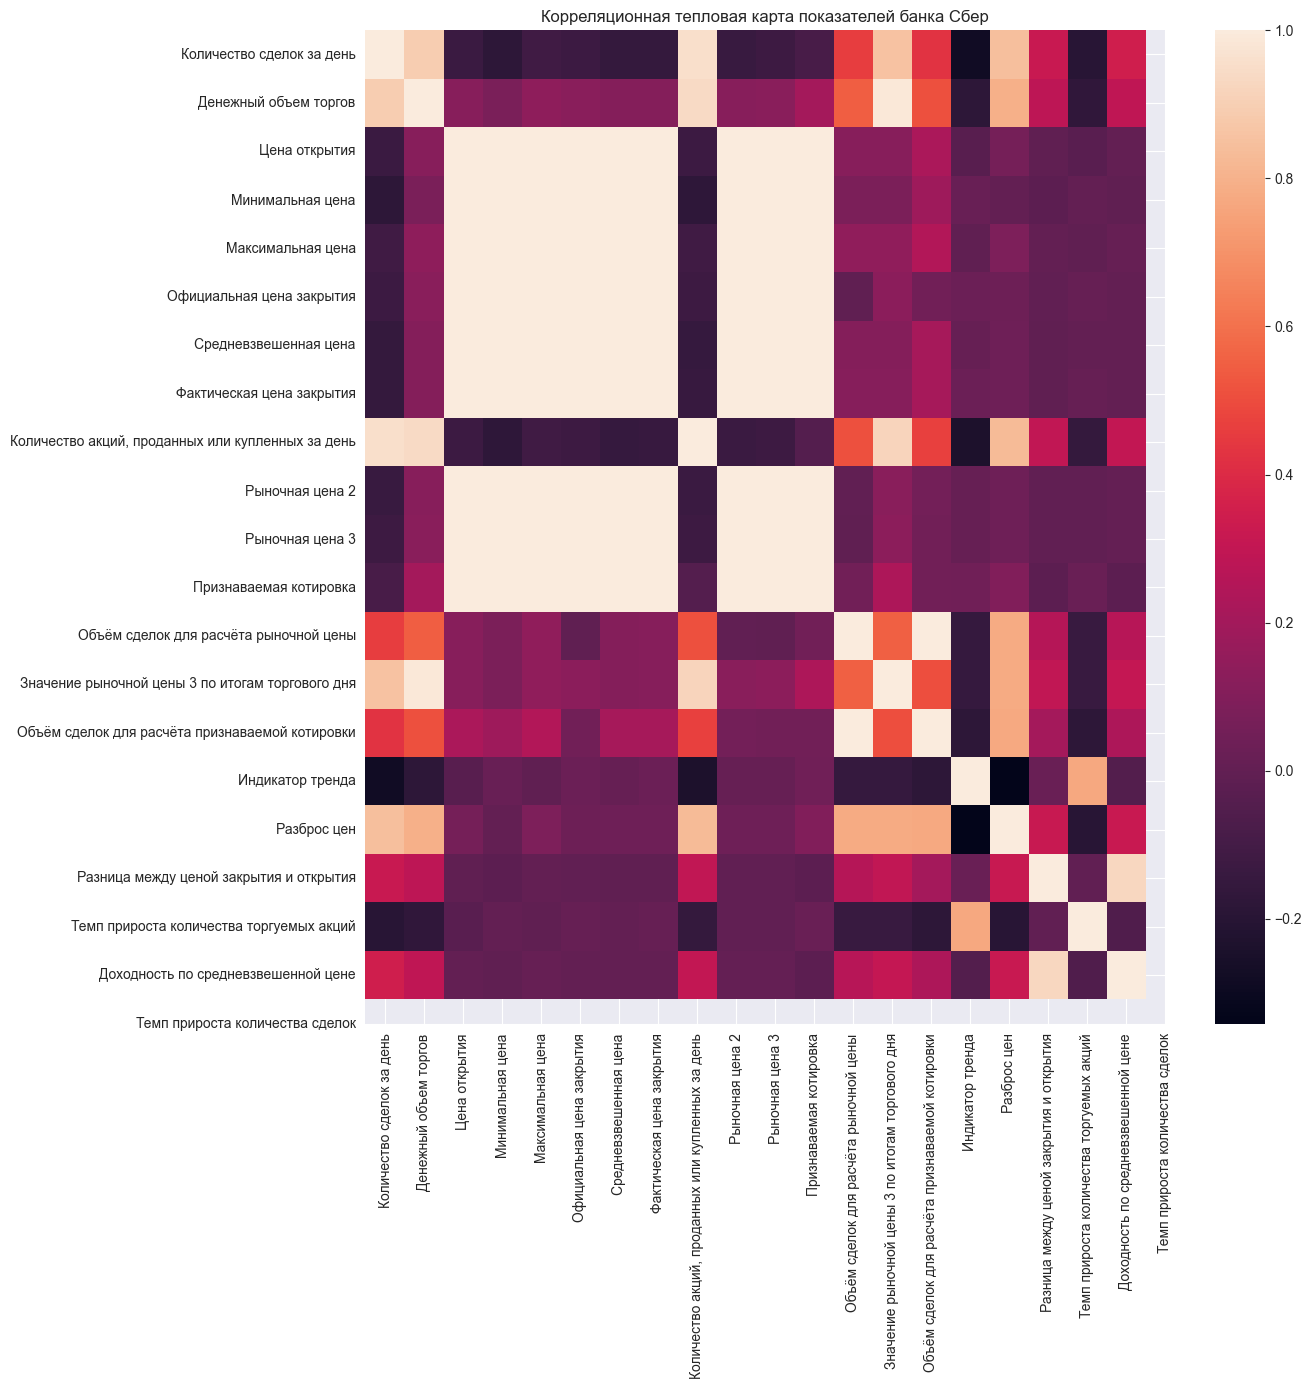

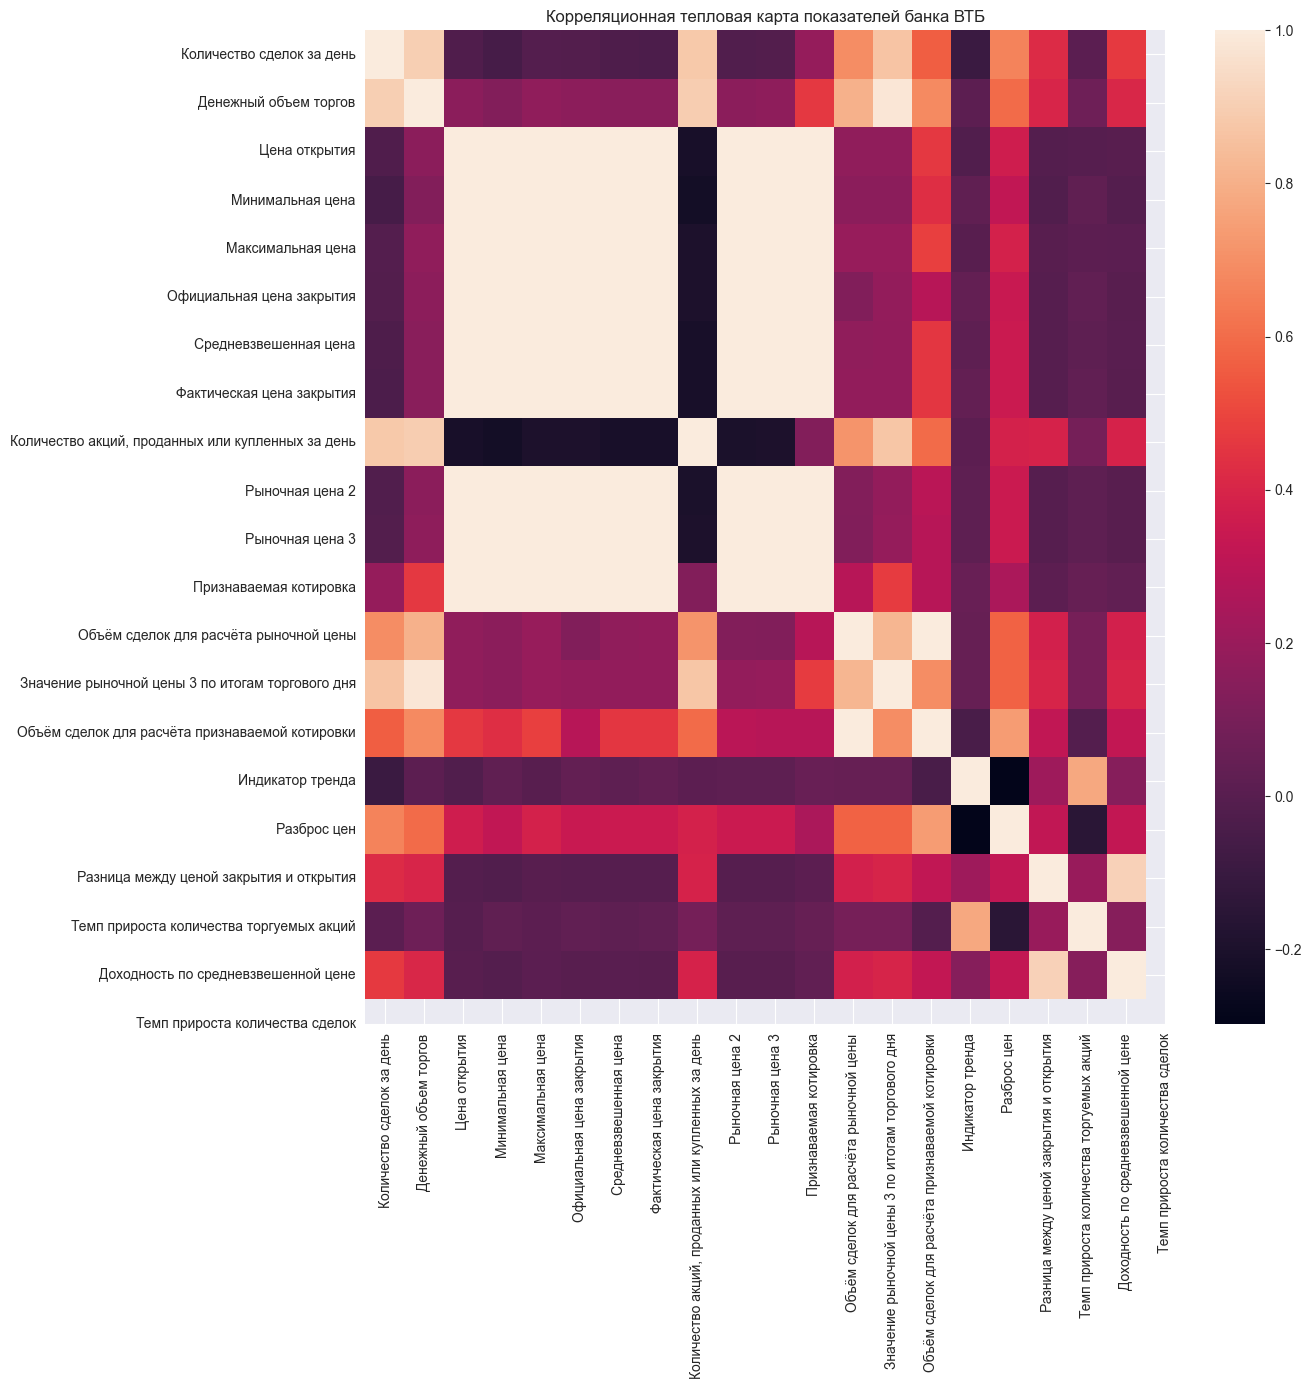

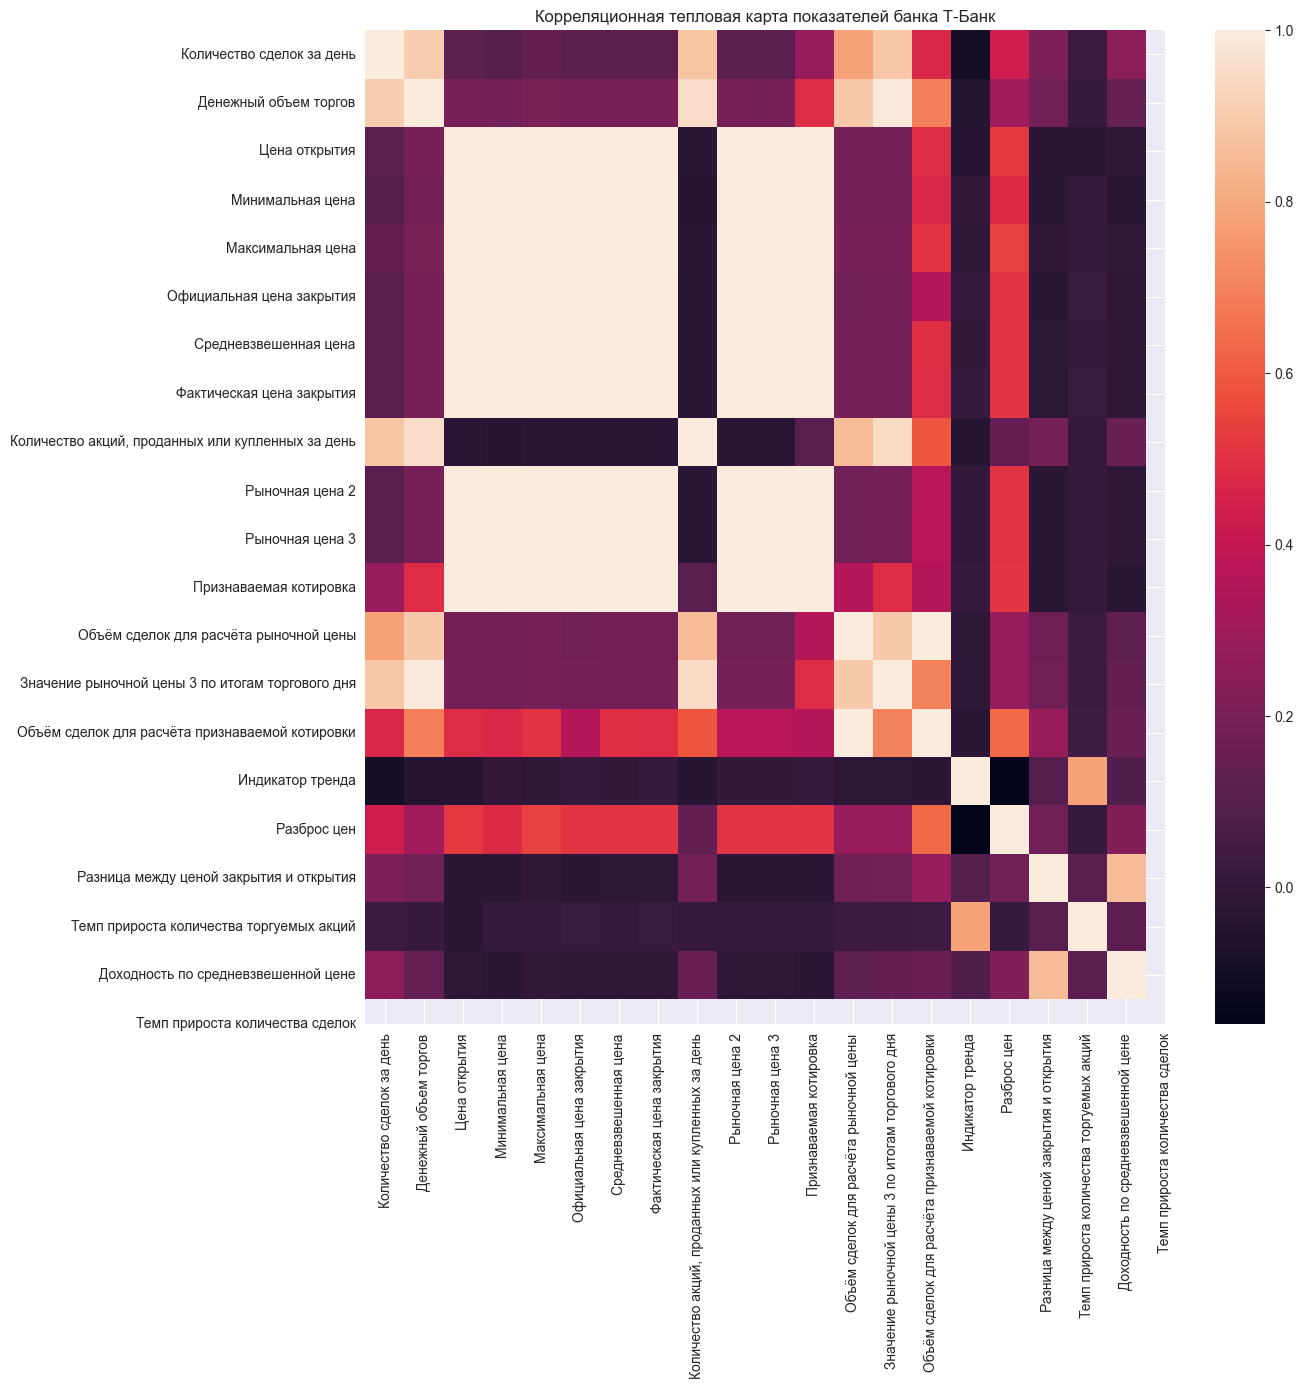

In [85]:
labels = ["Количество сделок за день", "Денежный объем торгов", "Цена открытия", "Минимальная цена", "Максимальная цена", "Официальная цена закрытия", "Средневзвешенная цена", "Фактическая цена закрытия", "Количество акций, проданных или купленных за день", "Рыночная цена 2", "Рыночная цена 3", "Признаваемая котировка", "Объём сделок для расчёта рыночной цены", "Значение рыночной цены 3 по итогам торгового дня", "Объём сделок для расчёта признаваемой котировки", "Индикатор тренда", "Разброс цен", "Разница между ценой закрытия и открытия", "Темп прироста количества торгуемых акций", "Доходность по средневзвешенной цене", "Темп прироста количества сделок"]
for df, name in zip(spfr, spbn):
    plt.figure(figsize=(12.9, 12.9))
    sns.heatmap(df.drop(["WAVAL (double)", "TRADINGSESSION (int32)", "TRADE_SESSION_DATE (date:10)"], axis=1).corr(numeric_only=True), xticklabels=labels, yticklabels=labels)
    plt.title("Корреляционная тепловая карта показателей банка " + name)
    plt.show()

Как видно:
Для Сбера среднее количество сделок в день было в районе 113 тыс. Средняя цена - 241 руб. Макс. число сделок - 1 559 658 в день. Макс. цена - 388 руб. Ст. отклонение по цене закрытия - 65 руб. Средняя доходность в районе нуля.
Для ВТБ среднее количество сделок в день было в районе 58 тыс. Средняя цена - 6 руб. Макс. число сделок - 435 775 в день. Макс. цена - 102 руб. Ст. отклонение по цене закрытия - 23 руб. Средняя доходность в районе нуля. Надо сказать, что статистика по ВТБ в черновом варианте не очень репрезентативна, т. к. банк сделал обратный сплит.
Для Т-банка среднее количество сделок в день было в районе 30 тыс. Средняя цена - 3244 руб. Макс. число сделок - 440 874 в день. Макс. цена - 8518 руб. Ст. отклонение по цене закрытия - 1620 руб. Средняя доходность в районе нуля.

По таблице корреляции видно, что все показатели, так или иначе обозначающие цену акций (цена открытия, закрытия, макс. цена, мин. цена, средневзвеш. цена) очень сильно коррелируют между собой (коэф. в районе 0,99). А вот доходность не коррелирует почти, разве что только с TRENDCLSPR (double) (коэф. в районе 0,7 - 0,8). Связано это со схожими механизмами расчета: доходность это разница средневзвешенных цен соседних дней, деленная на средневзвешенную цену предыдущего дня, а TRENDCLSPR (double) - индикатор тренда, разница между текущей ценой закрытия и предыдущей ценой закрытия, выраженная в процентах


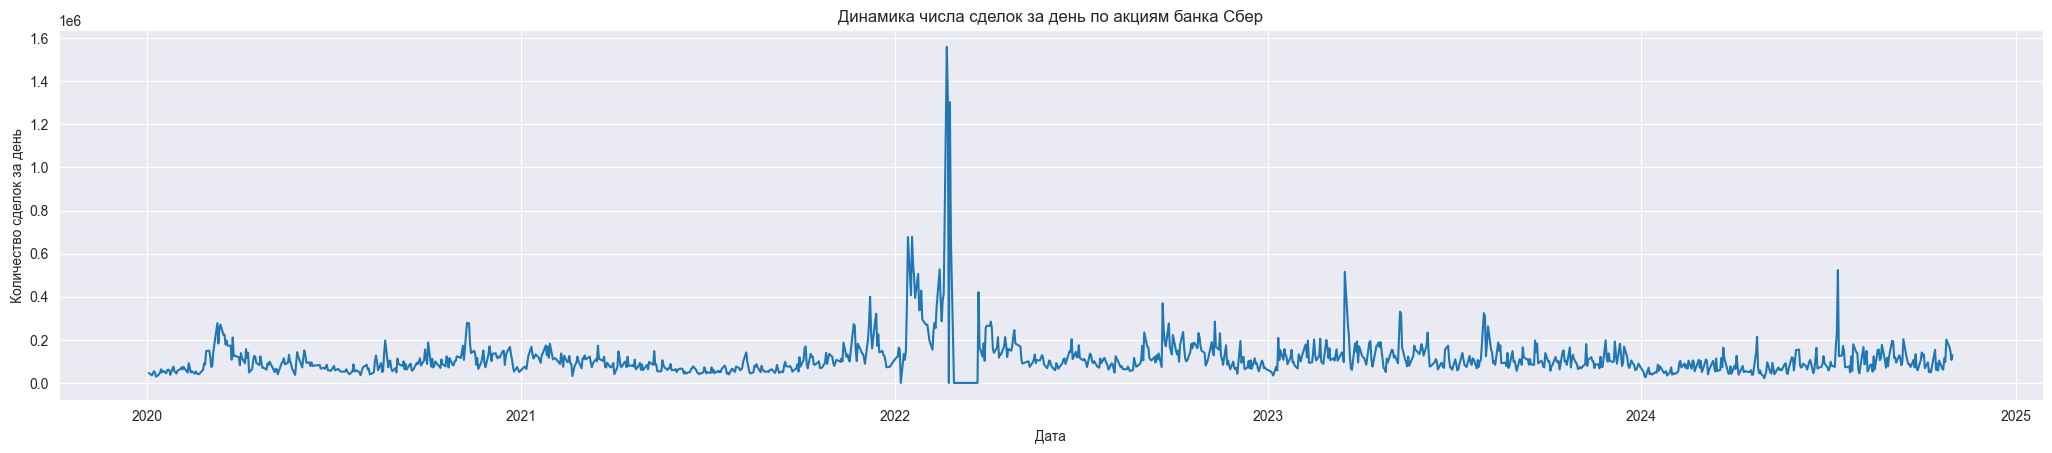

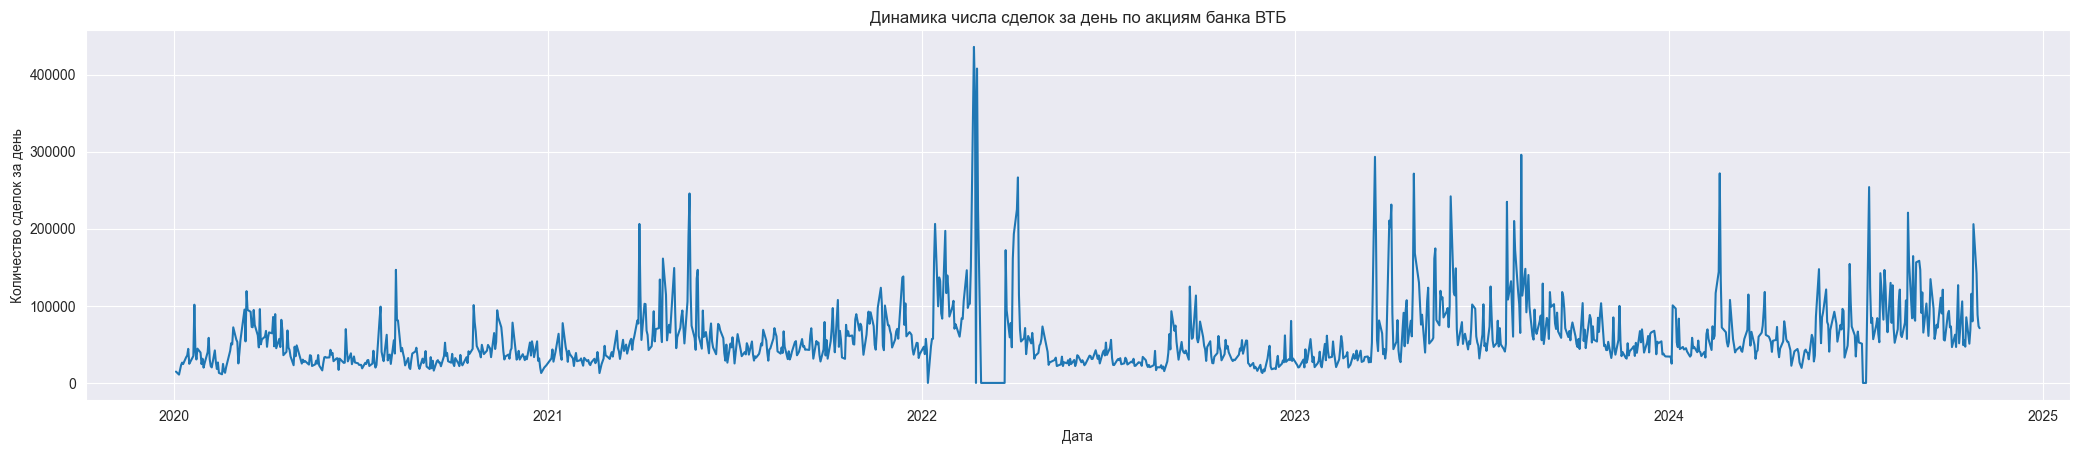

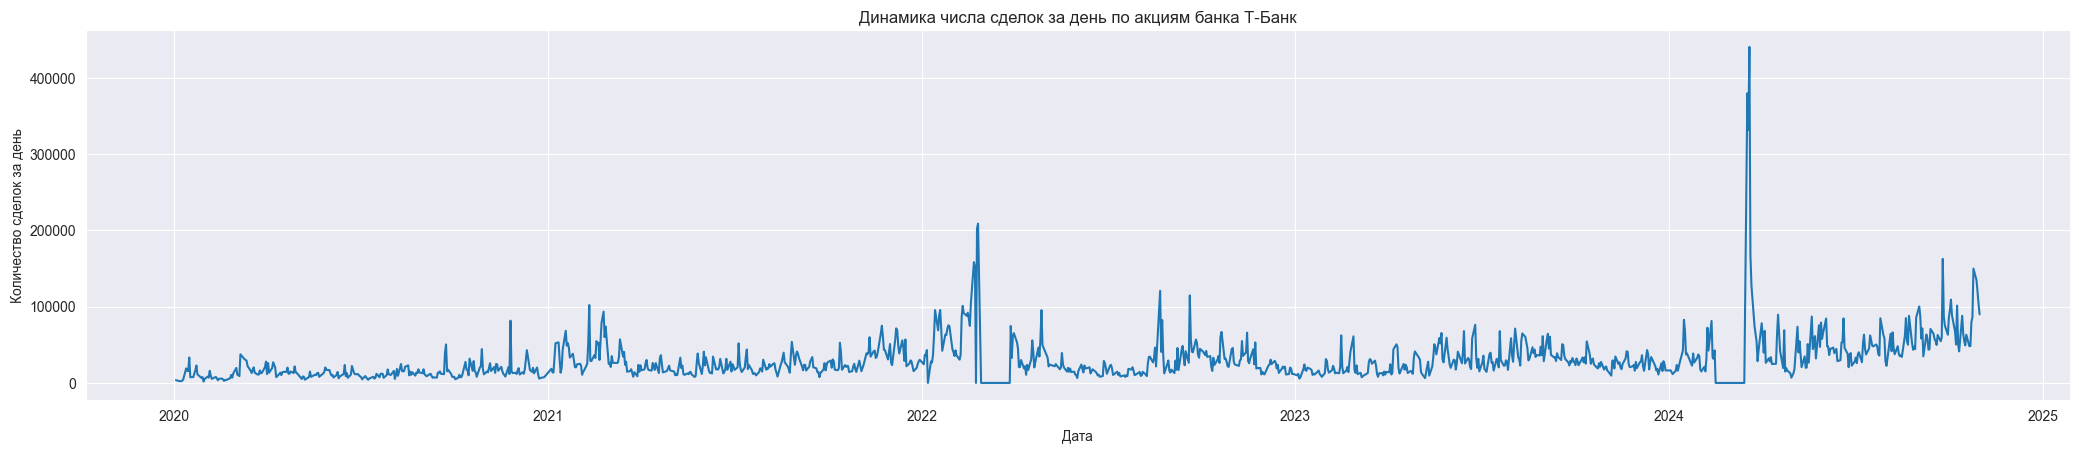

In [86]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    plt.figure(figsize=(25.6, 4.8))
    plt.plot(q, df["NUMTRADES (double)"])
    plt.xlabel('Дата')
    plt.ylabel('Количество сделок за день')
    plt.title('Динамика числа сделок за день по акциям банка ' + name)
    plt.show()

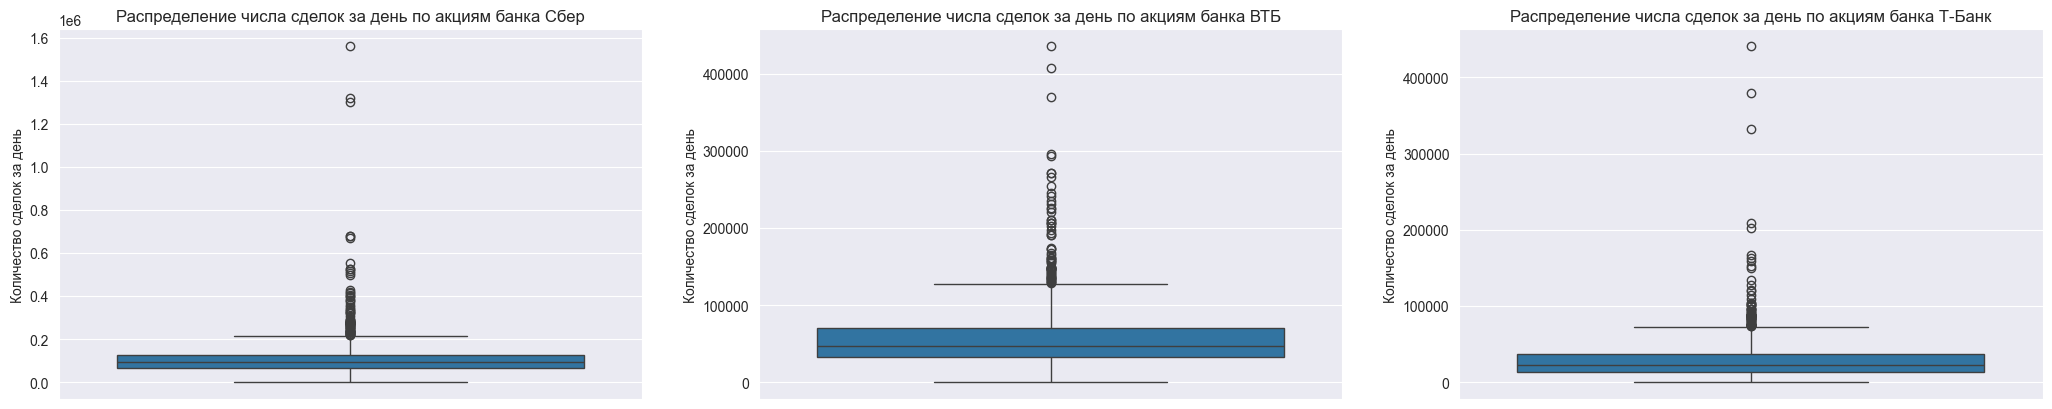

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(25.6, 4.8))
i = 0
for df, name in zip(spfr, spbn):
    sns.boxplot(data=df["NUMTRADES (double)"], ax=ax[i])
    ax[i].set_ylabel('Количество сделок за день')
    ax[i].set_title('Распределение числа сделок за день по акциям банка ' + name)
    i += 1
plt.show()

Как видим, у всех банков в какой-то момент резко подскочило число сделок, а затем упало до нуля (2022 год). Это связано с кризисом февраля 2022 года (резким повышением активности и приостановкой торгов). Число сделок ВТБ было очень волатильным в 2023-2024 гг., а в какой-то момент 2024 года у Т-Банка резко поднялось число сделок, правда потом упало.

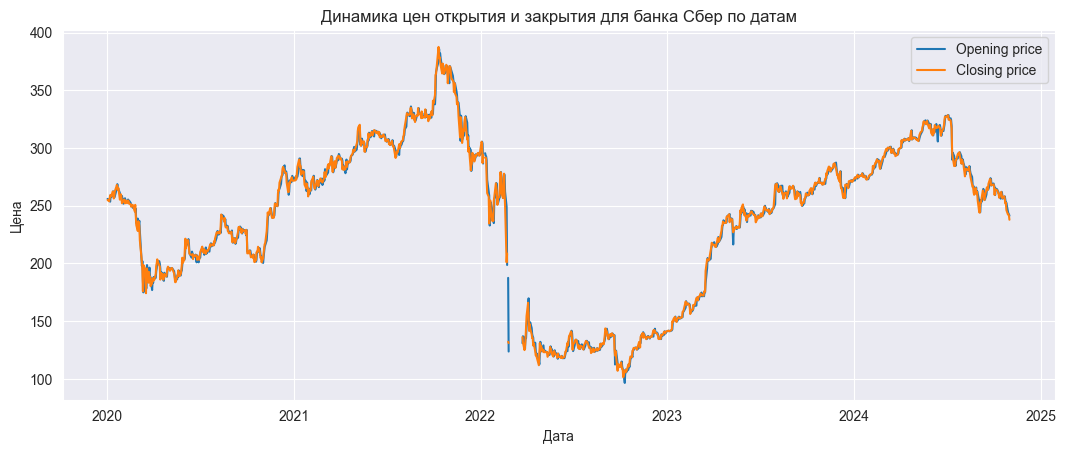

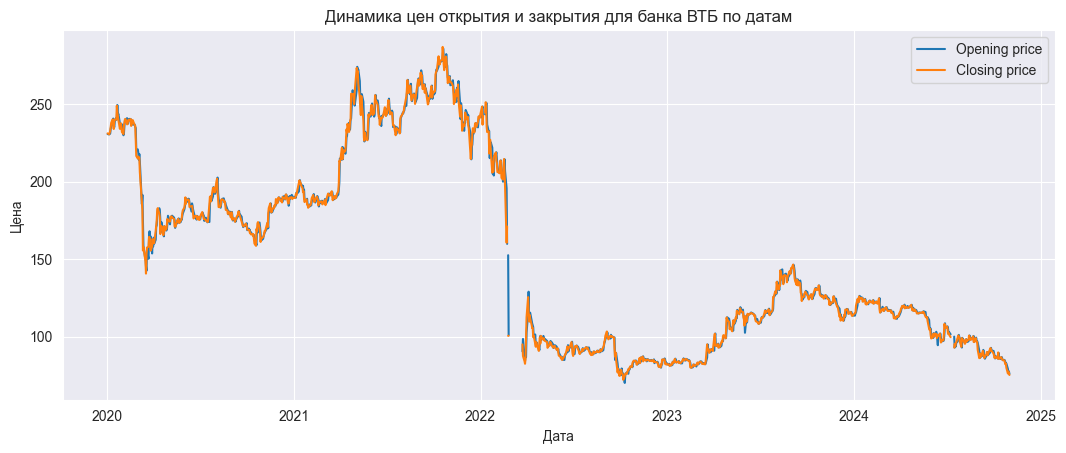

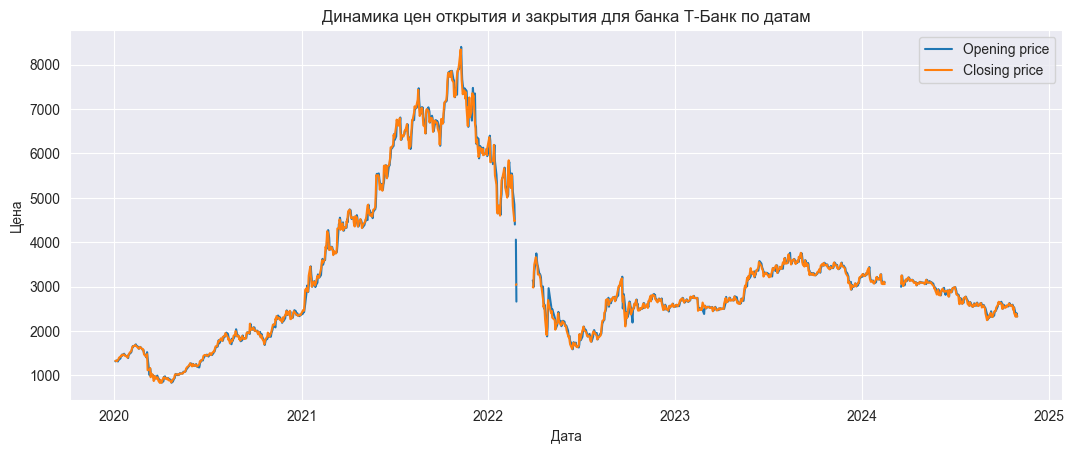

In [88]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    plt.figure(figsize=(12.8, 4.8))
    plt.plot(q, df["OPEN (double)"], label="Opening price")
    plt.plot(q, df["CLOSE (double)"], label="Closing price")
    plt.xlabel("Дата")
    plt.ylabel("Цена")
    plt.legend()
    plt.title('Динамика цен открытия и закрытия для банка ' + name + ' по датам')
    plt.show()

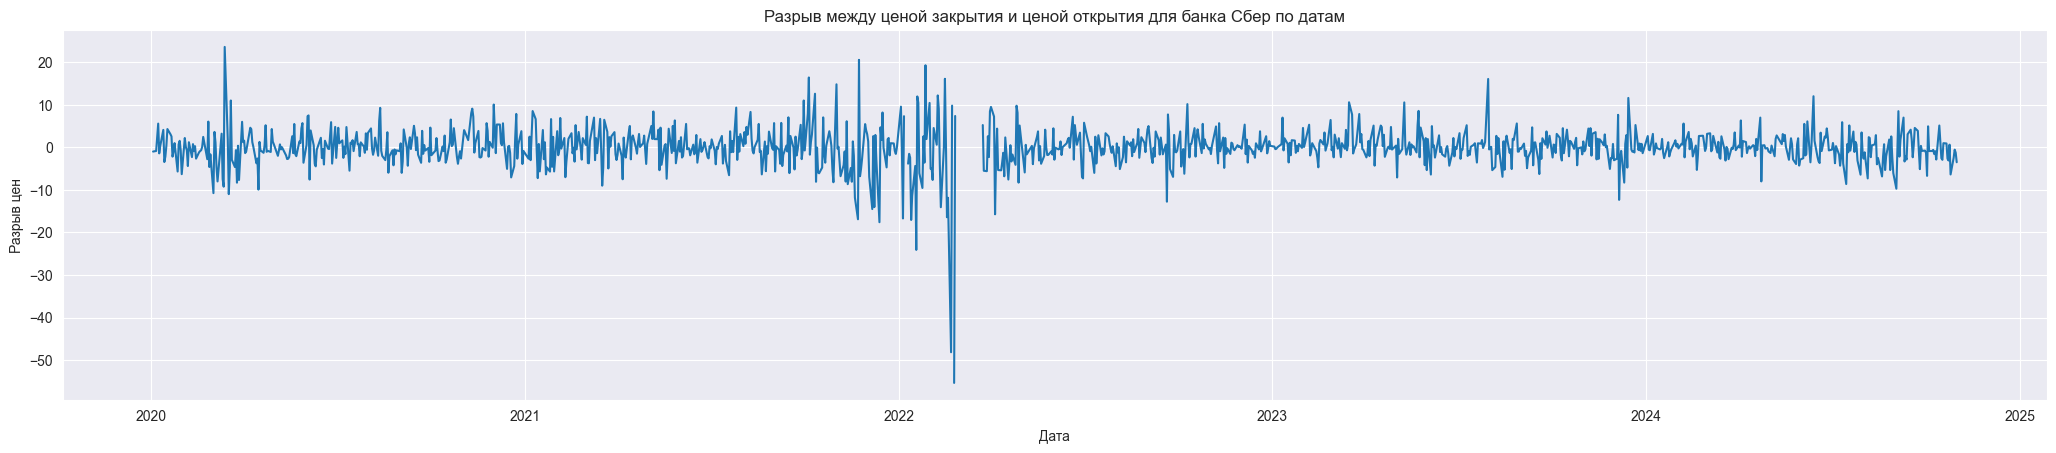

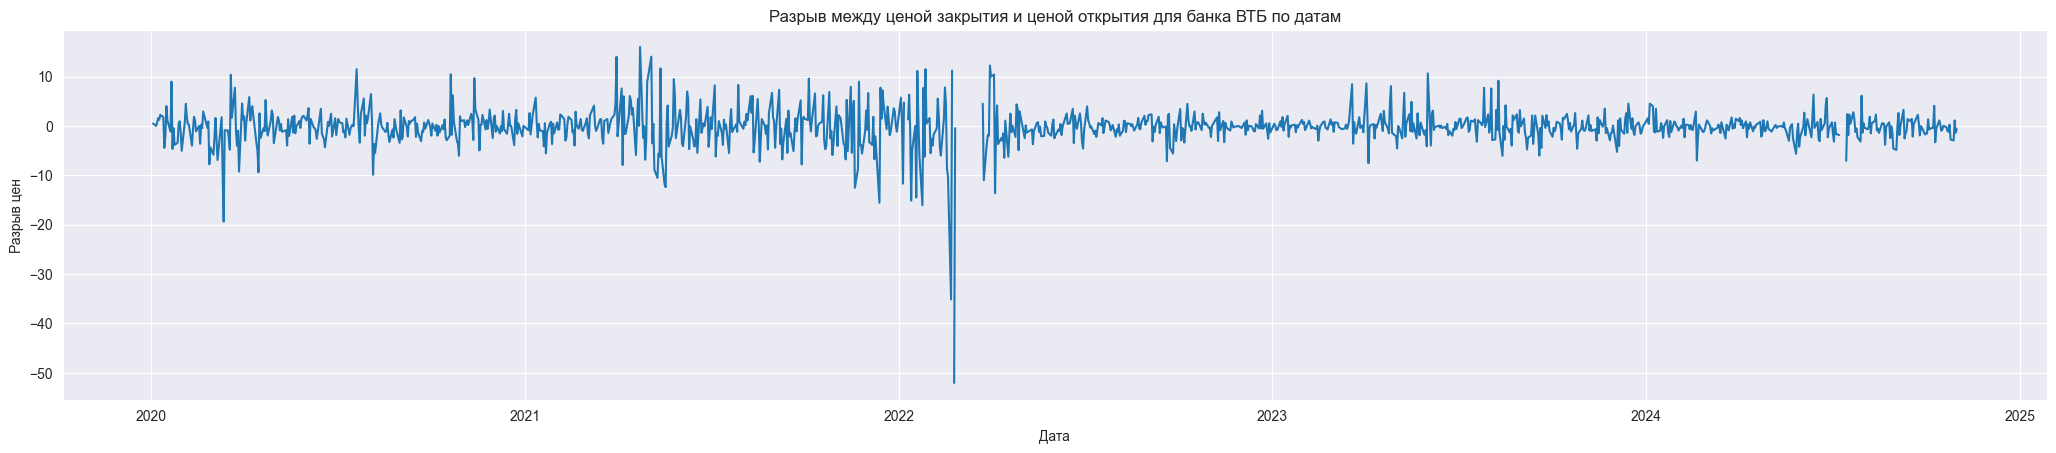

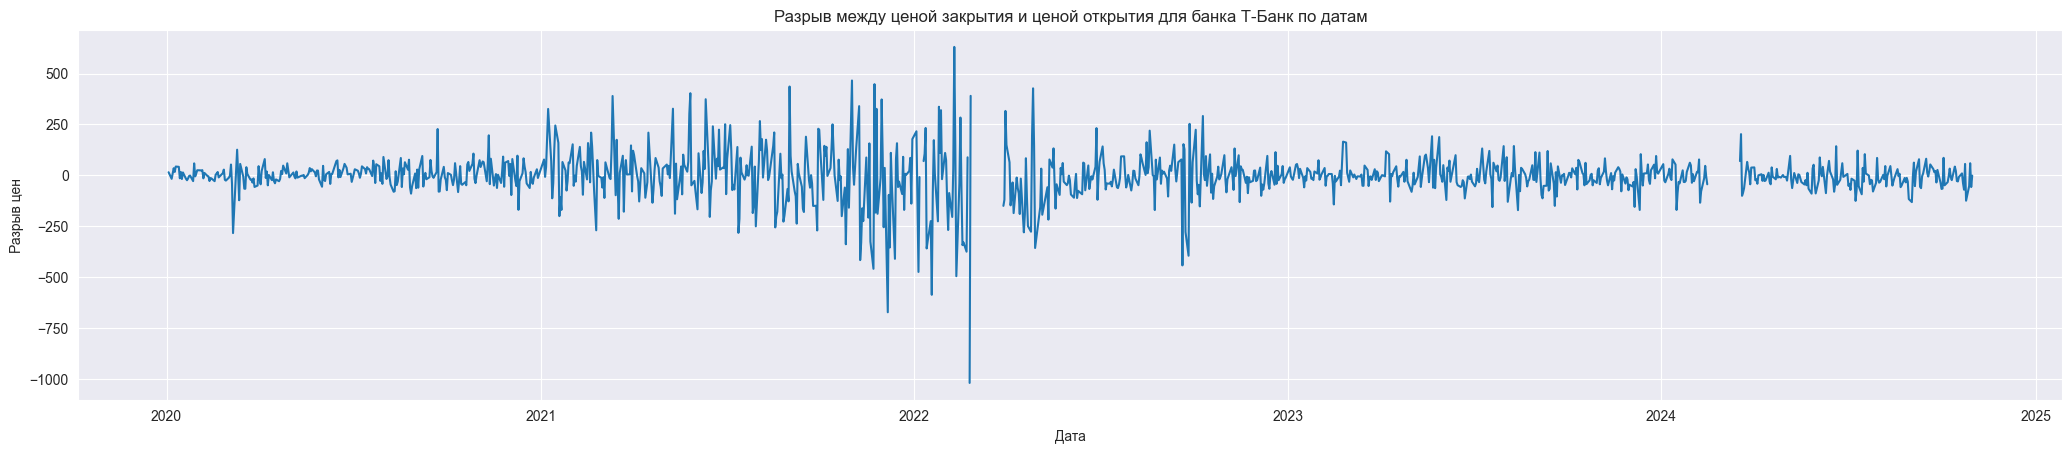

In [89]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    close_open_delta = df["CLOSE (double)"] - df["OPEN (double)"]
    plt.figure(figsize=(25.6, 4.8))
    plt.plot(q, close_open_delta)
    plt.title('Разрыв между ценой закрытия и ценой открытия для банка ' + name + ' по датам')
    plt.xlabel('Дата')
    plt.ylabel('Разрыв цен')
    plt.show()

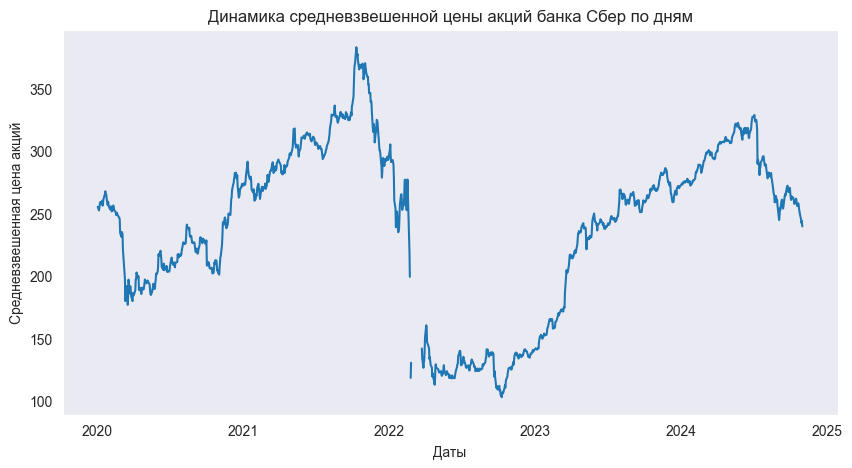

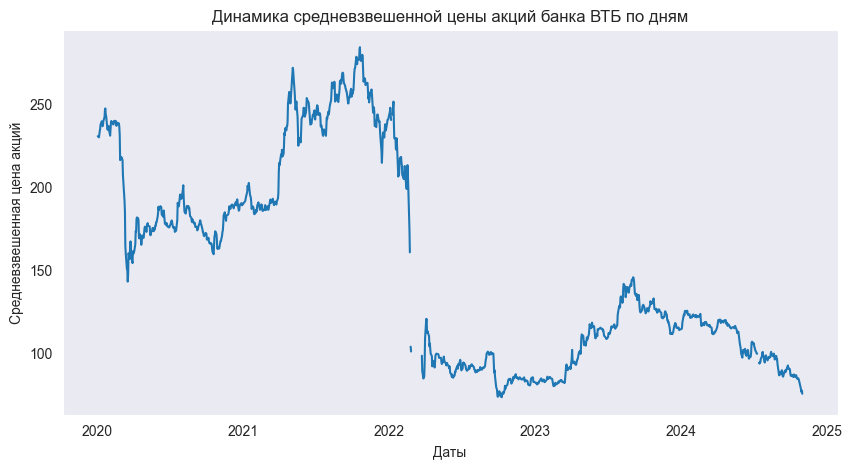

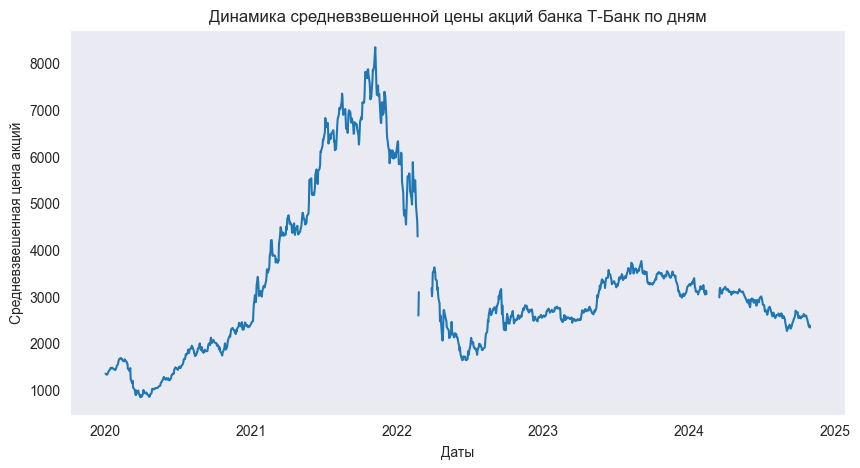

In [90]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    plt.figure(figsize = (10, 5))
    plt.plot(q, df['WAPRICE (double)'])
    plt.grid()
    plt.title('Динамика средневзвешенной цены акций банка ' + name + ' по дням')
    plt.xlabel('Даты')
    plt.ylabel('Средневзвешенная цена акций')
    plt.show()

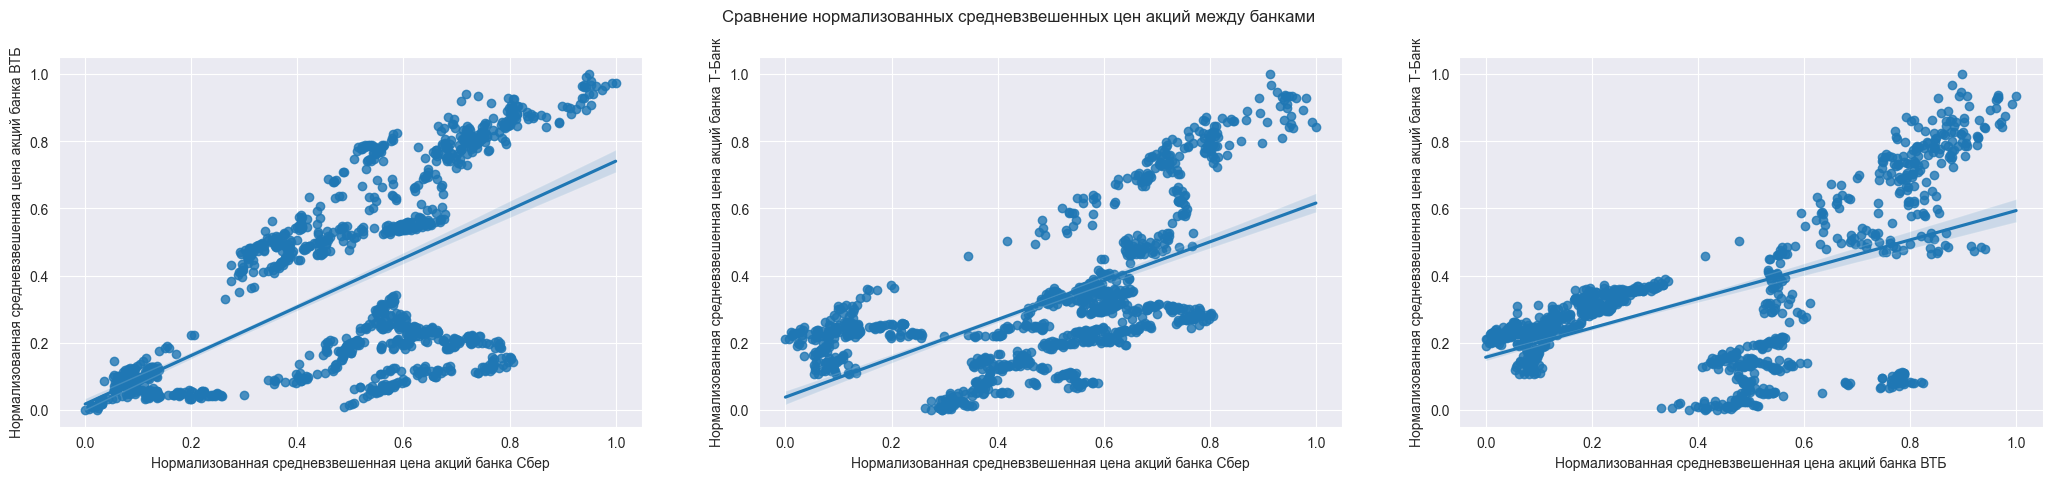

In [91]:
dfsber_scaled = (dfsber["WAPRICE (double)"] - dfsber["WAPRICE (double)"].min()) / (dfsber["WAPRICE (double)"].max() - dfsber["WAPRICE (double)"].min())
dfvtb_scaled = (dfvtb["WAPRICE (double)"] - dfvtb["WAPRICE (double)"].min()) / (dfvtb["WAPRICE (double)"].max() - dfvtb["WAPRICE (double)"].min())
dft_scaled = (dft["WAPRICE (double)"] - dft["WAPRICE (double)"].min()) / (dft["WAPRICE (double)"].max() - dft["WAPRICE (double)"].min())

fig, ax = plt.subplots(1, 3, figsize=(25.6, 4.8))
i = 0
pairs = list()
for df_i, name_i in zip([dfsber_scaled, dfvtb_scaled, dft_scaled], spbn):
    for df_j, name_j in zip([dfsber_scaled, dfvtb_scaled, dft_scaled], spbn):
        if {name_i, name_j} in pairs or name_i == name_j:
            continue
        sns.regplot(x=df_i, y=df_j, ax=ax[i])
        pairs.append({name_i, name_j})
        ax[i].set_xlabel('Нормализованная средневзвешенная цена акций банка ' + name_i)
        ax[i].set_ylabel('Нормализованная средневзвешенная цена акций банка ' + name_j)
        i += 1
plt.suptitle("Сравнение нормализованных средневзвешенных цен акций между банками")
plt.show()

До кризиса определенного момента 2021 года (выясним конкретику позже) акции Сбера и Т росли. Затем падали до февраля 2022 г. Затем были приостановлены торги.  Затем акции продолжили падать немного, потом пошли вверх, а потом опять начали падать, но медленно.
У ВТБ отдельная история. До сплита акции стоили очень мало, график не отражает динамику. Виден момент приостановки торгов в марте 2022 г. А после сплита акции взлетели до 100, но демонстрировали нисходящий тренд.

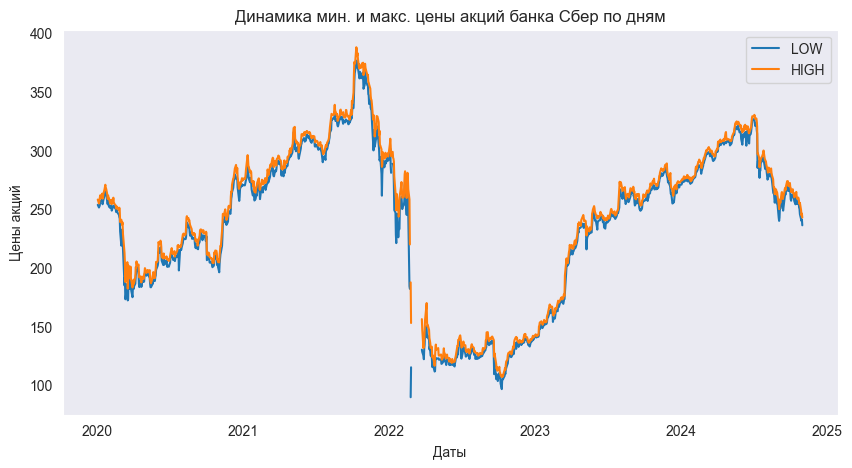

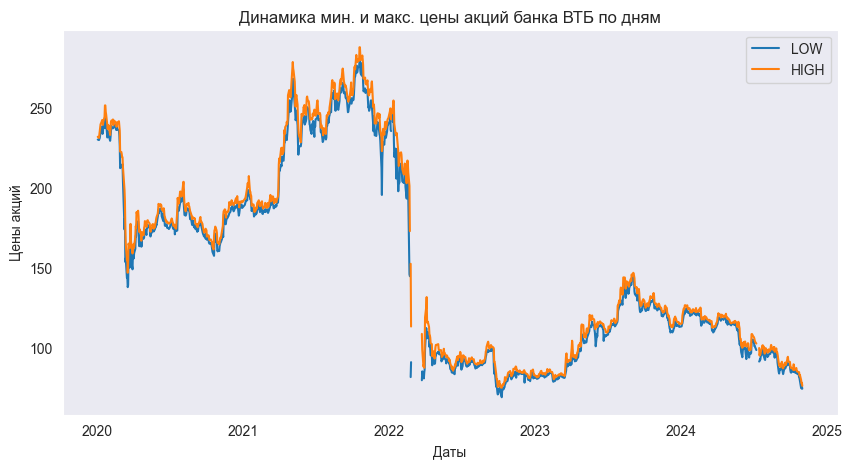

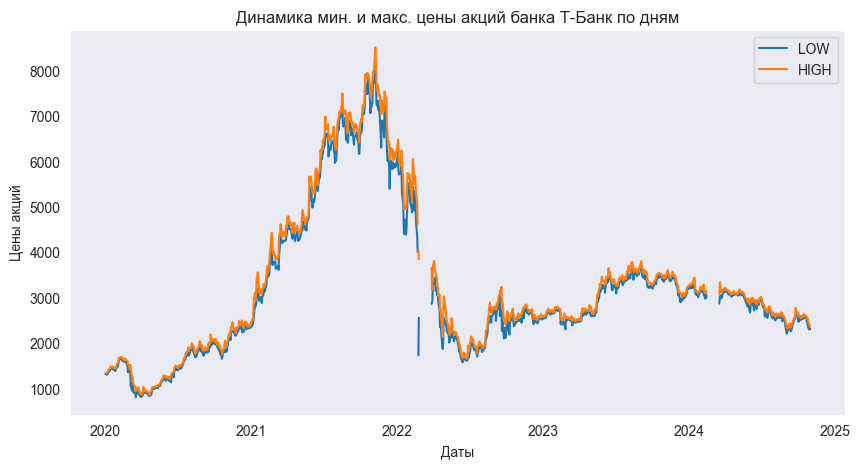

In [92]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    plt.figure(figsize = (10, 5))
    plt.plot(q, df['LOW (double)'], label = 'LOW')
    plt.plot(q, df['HIGH (double)'], label = 'HIGH' )
    plt.grid()
    plt.legend()
    plt.title('Динамика мин. и макс. цены акций банка ' + name +' по дням')
    plt.xlabel('Даты')
    plt.ylabel('Цены акций')
    plt.show()

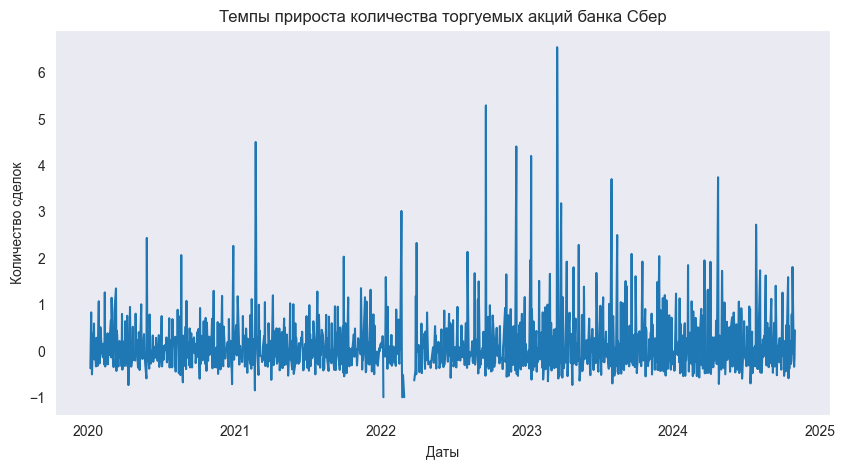

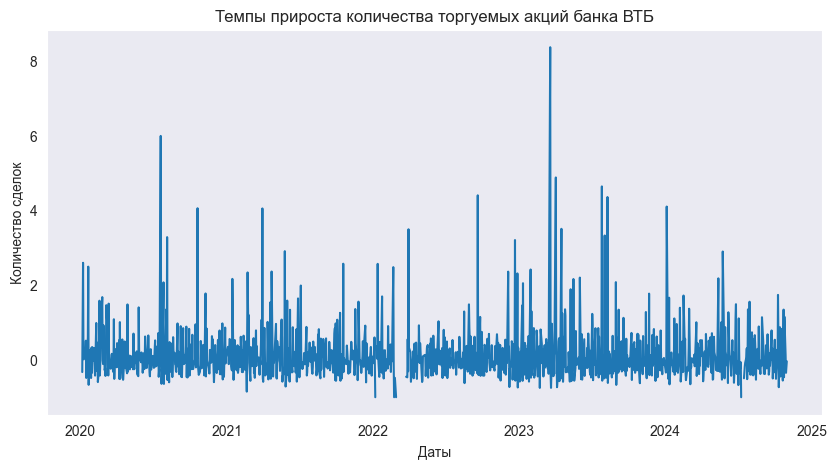

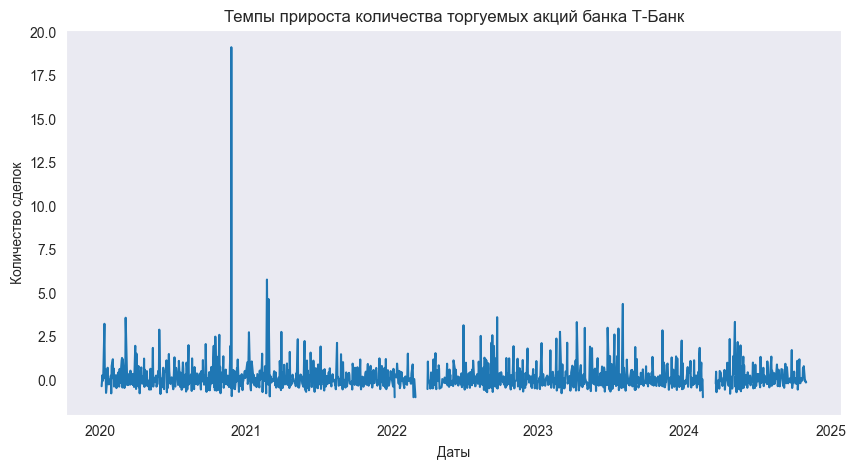

In [93]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    plt.figure(figsize = (10, 5))
    plt.plot(q, df['Темп прироста количества торгуемых акций'])
    plt.grid()
    plt.title('Темпы прироста количества торгуемых акций банка ' + name)
    plt.xlabel('Даты')
    plt.ylabel('Количество сделок')
    plt.show()

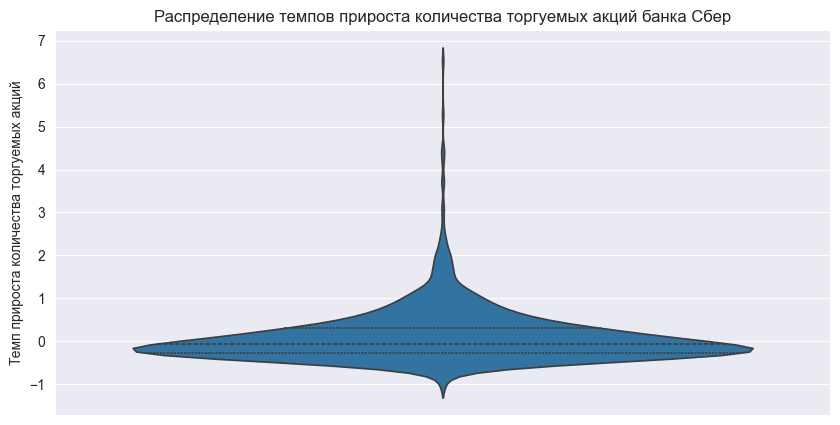

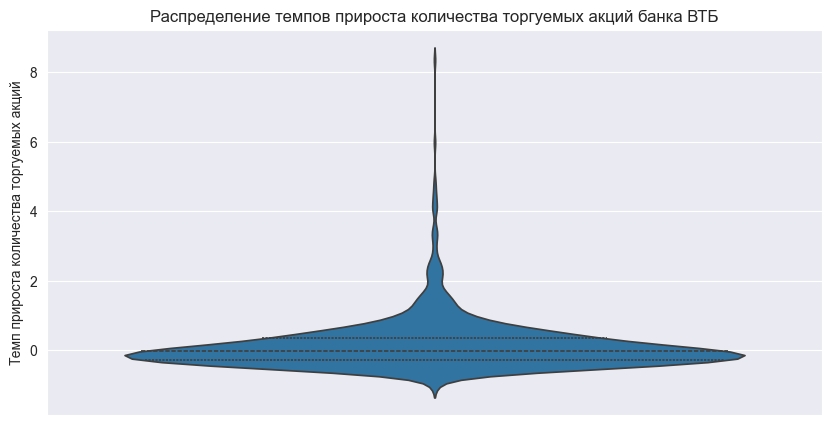

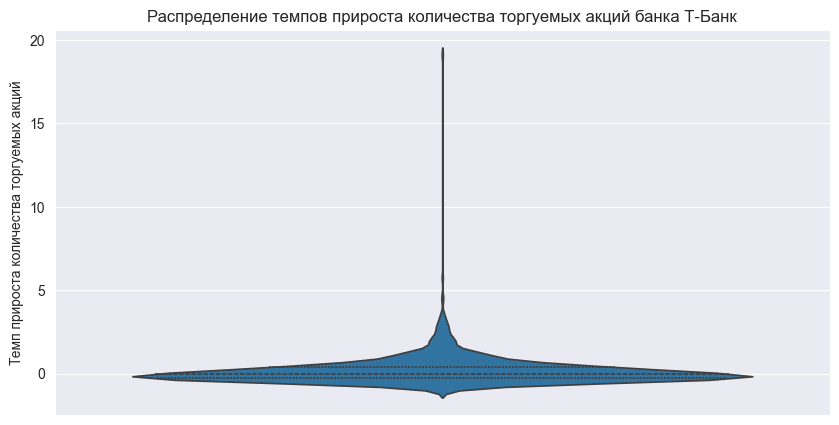

In [94]:
for df, name in zip(spfr, spbn):
    plt.figure(figsize = (10, 5))
    sns.violinplot(df['Темп прироста количества торгуемых акций'], inner='quartile')
    plt.title('Распределение темпов прироста количества торгуемых акций банка ' + name)
    plt.show()

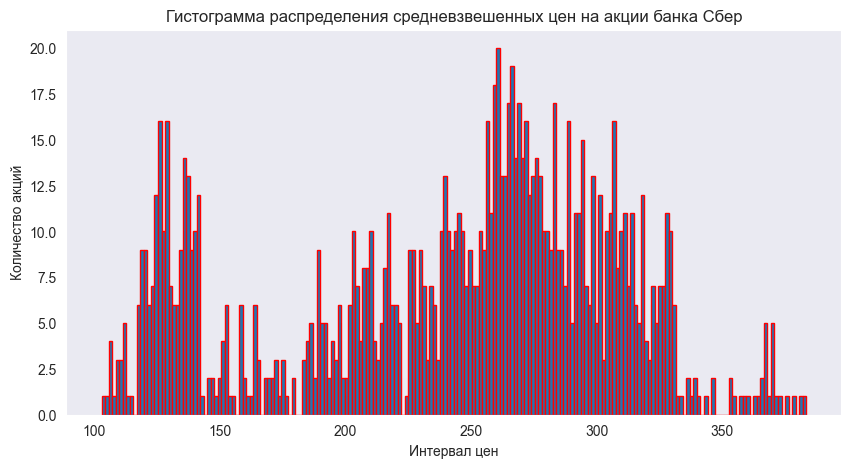

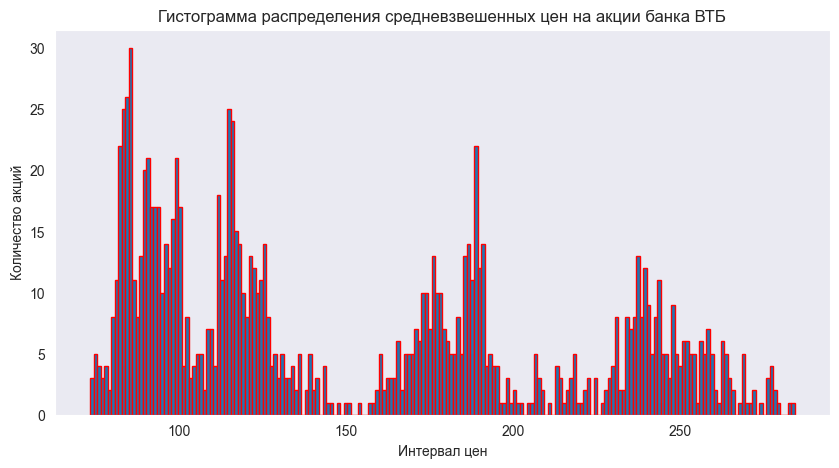

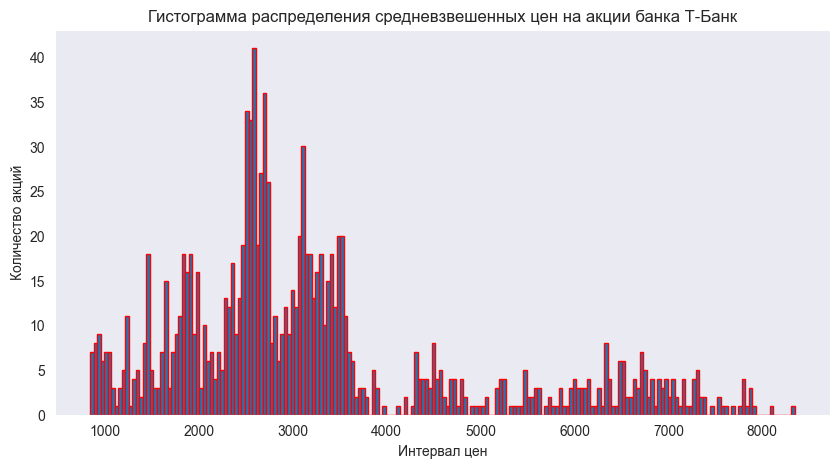

In [95]:
for df, name in zip(spfr, spbn):
    plt.figure(figsize = (10, 5))
    plt.hist(df['WAPRICE (double)'], bins = 200, edgecolor = 'red')
    plt.grid()
    plt.title('Гистограмма распределения средневзвешенных цен на акции банка ' + name)
    plt.xlabel('Интервал цен')
    plt.ylabel('Количество акций')
    plt.show()

По гистограмме цен видно, что основная масса цен Сбера сосредоточилась в промежутке от 200 до 350. Также большая доля есть от 100 до 150.
Для ВТБ основная масса в районе нуля, остальные цены имеют очень низкую частоту. Это к истории с дешевыми акциями и сплитом.
Для Т-банка есть большое скопление в промежутке от 1000 до 4000 руб., а цены выше имеют более низкую частоту.

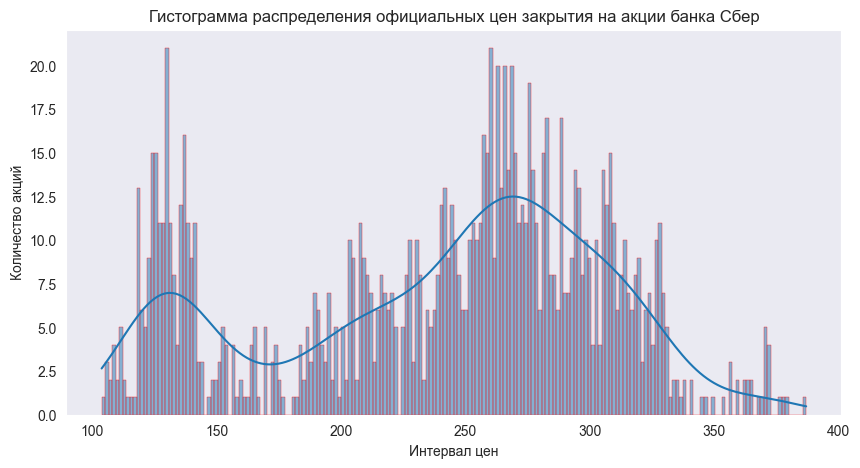

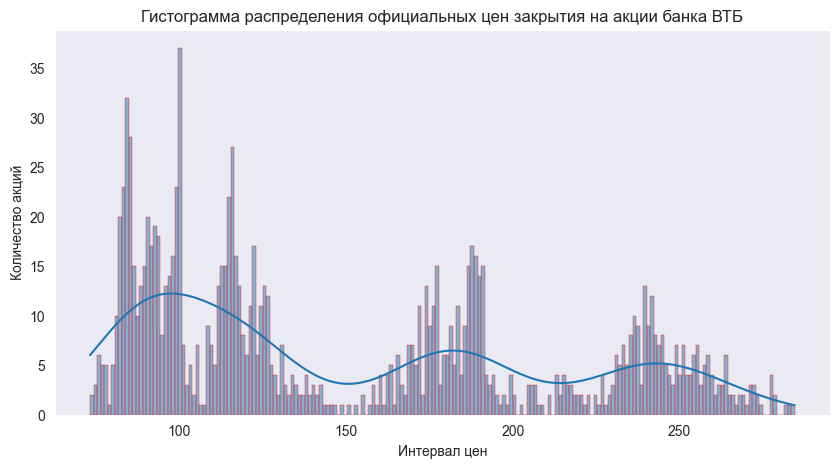

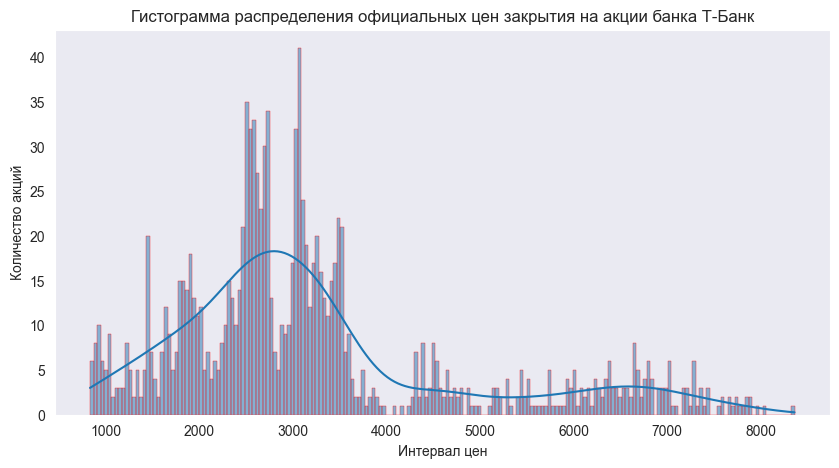

In [96]:
for df, name in zip(spfr, spbn):
    plt.figure(figsize = (10, 5))
    sns.histplot(df['LEGALCLOSEPRICE (double)'], bins = 200, edgecolor = 'red', kde = True)
    plt.grid()
    plt.title('Гистограмма распределения официальных цен закрытия на акции банка ' + name)
    plt.xlabel('Интервал цен')
    plt.ylabel('Количество акций')
    plt.show()

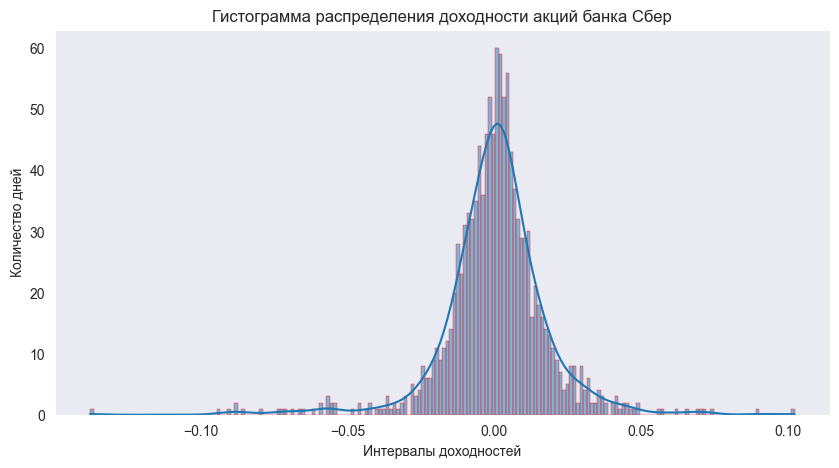

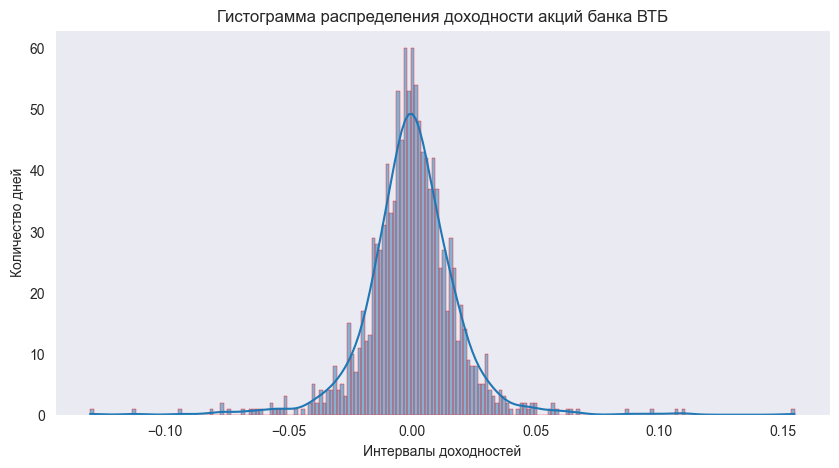

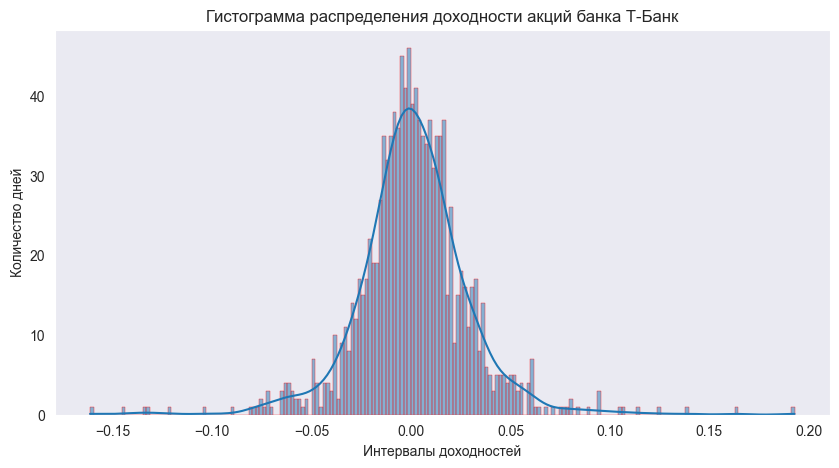

In [97]:
for df, name in zip(spfr, spbn):
    plt.figure(figsize = (10, 5))
    sns.histplot(df['Доходность по средневзвешенной цене'], bins = 200, edgecolor = 'red', kde = True)
    plt.grid()
    plt.title('Гистограмма распределения доходности акций банка ' + name)
    plt.xlabel('Интервалы доходностей')
    plt.ylabel('Количество дней')
    plt.show()

Гистограммы доходностей напоминают нормальное распределение с нулевым мат. ожиданием. Хвосты относительно равномерные. Отклоняясь по графикам от нулевой доходности в любую сторону, частота дней, в которых была такая доходность, убывает.

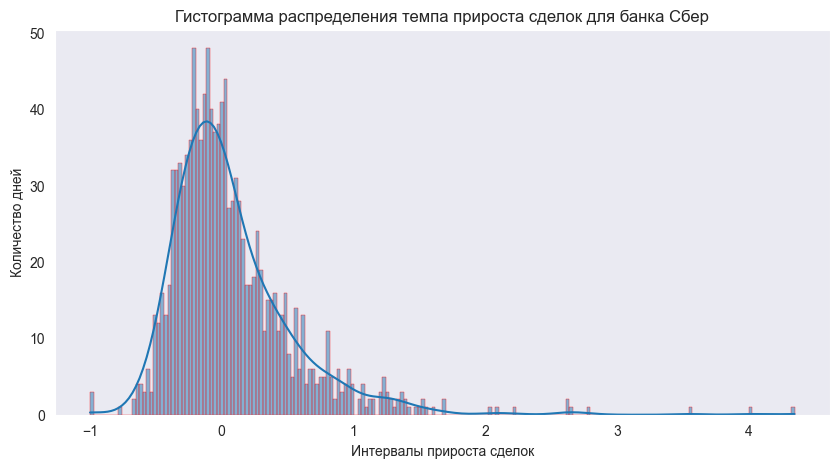

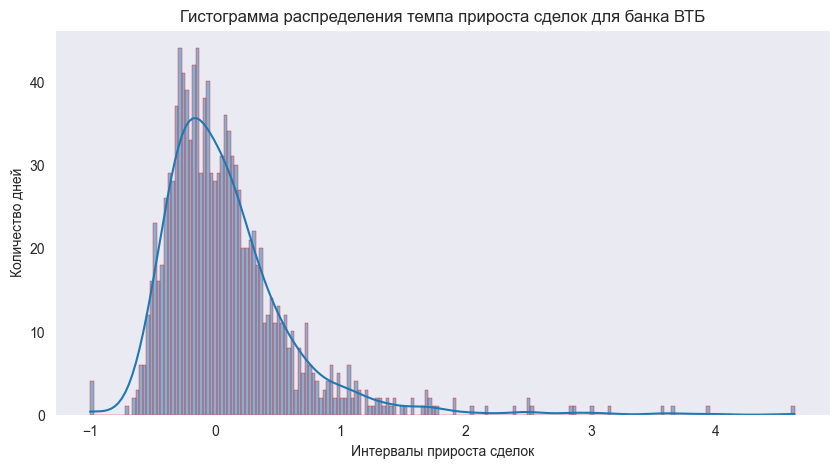

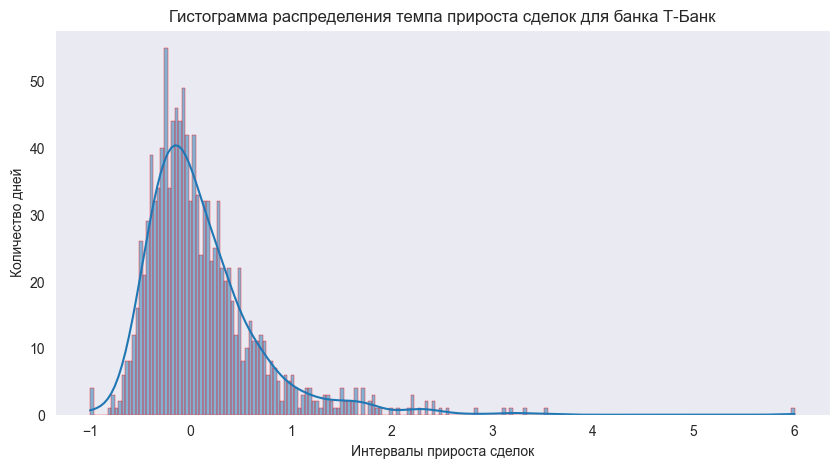

In [98]:
for df, name in zip(spfr, spbn):
    plt.figure(figsize = (10, 5))
    sns.histplot(df['Темп прироста количества сделок'], bins = 200, edgecolor = 'red', kde = True)
    plt.grid()
    plt.title('Гистограмма распределения темпа прироста сделок для банка ' + name)
    plt.xlabel('Интервалы прироста сделок')
    plt.ylabel('Количество дней')
    plt.show()

# Гипотезы
### 1. Распределение доходностей близко к нормальному
### 2. Между показателями Сбера и Т-Банка (такими, как цены и доходности) наблюдается высокая корреляция.
### 3. Распределение прироста сделок близко к логнормальному.

# Присоединённая таблица

In [99]:
dfsber = dfsber.drop(["BOARDID (string:12)", "SHORTNAME (string:189)", "SECID (string:36)", "CURRENCYID (string:9)", "WAVAL (double)", "TRADINGSESSION (int32)", 'TRADE_SESSION_DATE (date:10)'], axis=1)
dfsber['TRADEDATE (date:10)'] = pd.to_datetime(dfsber['TRADEDATE (date:10)'])
dfsber = dfsber.set_index('TRADEDATE (date:10)')

dfvtb = dfvtb.drop(["BOARDID (string:12)", "SHORTNAME (string:189)", "SECID (string:36)", "CURRENCYID (string:9)", "WAVAL (double)", "TRADINGSESSION (int32)", 'TRADE_SESSION_DATE (date:10)'], axis=1)
dfvtb['TRADEDATE (date:10)'] = pd.to_datetime(dfvtb['TRADEDATE (date:10)'])
dfvtb = dfvtb.set_index('TRADEDATE (date:10)')

dft = dft.drop(["BOARDID (string:12)", "SHORTNAME (string:189)", "SECID (string:36)", "CURRENCYID (string:9)", "WAVAL (double)", "TRADINGSESSION (int32)", 'TRADE_SESSION_DATE (date:10)'], axis=1)
dft['TRADEDATE (date:10)'] = pd.to_datetime(dft['TRADEDATE (date:10)'])
dft = dft.set_index('TRADEDATE (date:10)')

In [100]:
df_merged = pd.merge(pd.merge(dfsber, dfvtb, left_index=True, right_index=True, suffixes=(' для Сбер', ' для ВТБ')), dft.add_suffix(' для Т-Банк'), left_index=True, right_index=True)
df_merged

,NUMTRADES (double) для Сбер,VALUE (double) для Сбер,OPEN (double) для Сбер,LOW (double) для Сбер,HIGH (double) для Сбер,LEGALCLOSEPRICE (double) для Сбер,WAPRICE (double) для Сбер,CLOSE (double) для Сбер,VOLUME (double) для Сбер,MARKETPRICE2 (double) для Сбер,...,MP2VALTRD (double) для Т-Банк,MARKETPRICE3TRADESVALUE (double) для Т-Банк,ADMITTEDVALUE (double) для Т-Банк,TRENDCLSPR (double) для Т-Банк,Были ли торги для Т-Банк,Разброс цен для Т-Банк,Категория по средневзвешенной цене для Т-Банк,Темп прироста количества торгуемых акций для Т-Банк,Доходность по средневзвешенной цене для Т-Банк,Темп прироста количества сделок для Т-Банк
TRADEDATE (date:10),,,,,,,,,,,,,,,,,,,,,
2020-01-03,46191,9.165475e+09,255.99,253.70,258.19,255.00,255.62,255.00,35851840,255.65,...,1.156614e+08,1.156614e+08,115661375.8,1.62,да,35.8,low,NaN,NaN,NaN
2020-01-06,34925,5.646010e+09,254.75,251.40,254.84,253.90,252.64,253.90,22348300,252.64,...,7.186416e+07,7.186416e+07,71864157.0,-0.72,да,37.4,low,-0.367784,-0.017257,-0.303681
2020-01-08,54429,1.048588e+10,253.57,253.03,259.15,259.15,256.88,259.15,40817240,256.90,...,9.221384e+07,9.221384e+07,92213837.2,2.07,да,37.8,low,0.270563,0.009991,-0.122547
2020-01-09,49305,9.936032e+09,259.40,257.01,261.76,257.99,259.23,257.99,38329020,259.23,...,8.827762e+07,8.827762e+07,88277620.0,1.23,да,34.2,low,-0.059093,0.017386,0.322684
2020-01-10,28908,4.864405e+09,257.86,256.88,259.25,258.19,258.05,258.19,18851390,258.04,...,1.012924e+08,1.012924e+08,101292419.2,2.31,да,46.0,low,0.127916,0.017236,0.445135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25,201659,2.012604e+10,252.72,245.70,255.35,247.27,249.74,246.35,80587930,250.00,...,1.300570e+10,1.300570e+10,NaN,-4.86,да,152.5,low,0.783189,-0.013750,0.732276
2024-10-28,166891,1.765287e+10,245.02,241.61,249.00,242.80,245.36,242.56,71940990,245.68,...,1.311936e+10,1.311936e+10,NaN,-3.59,да,91.5,low,-0.067471,-0.049101,-0.102049
2024-10-29,147128,1.143009e+10,243.20,239.88,244.60,242.80,242.50,242.66,47134580,242.43,...,1.231961e+10,1.231961e+10,NaN,2.91,да,95.0,low,-0.038278,-0.002975,-0.115377


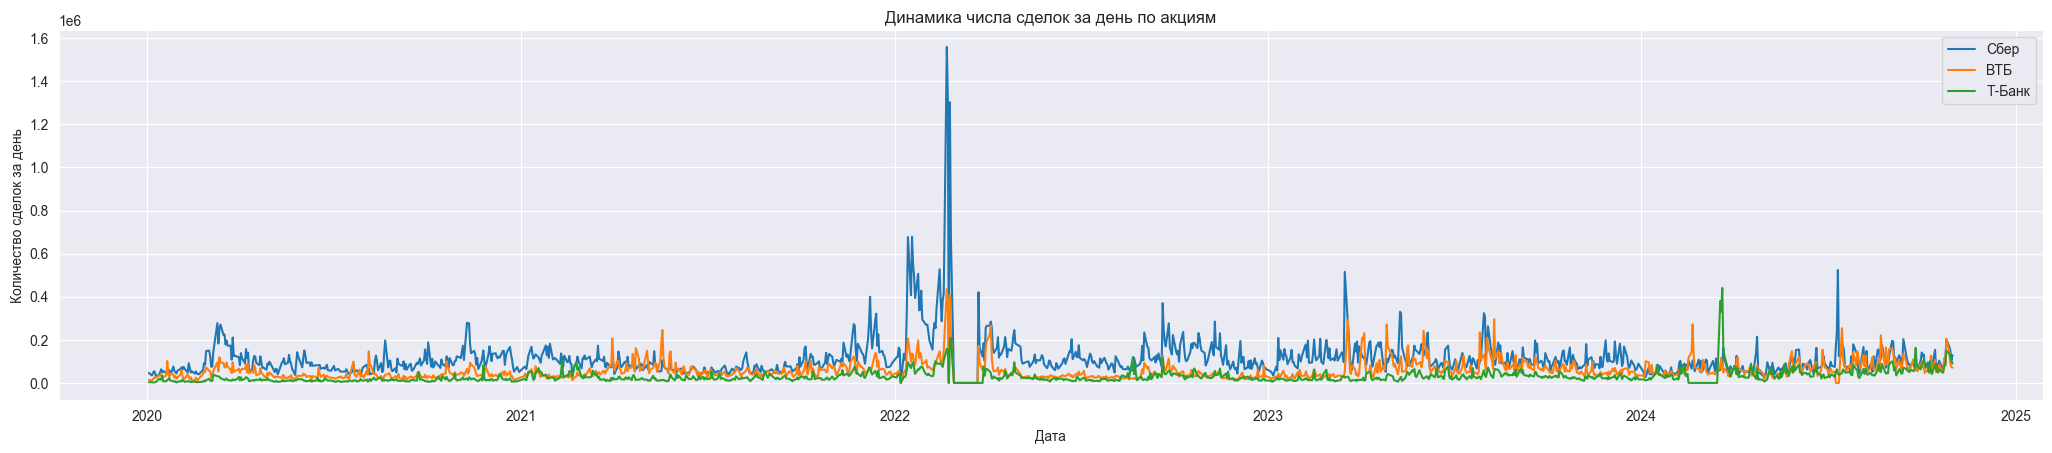

In [101]:
plt.figure(figsize=(25.6, 4.8))
for name in spbn:
    plt.plot(df_merged.index, df_merged[f"NUMTRADES (double) для {name}"], label=name)
plt.xlabel('Дата')
plt.ylabel('Количество сделок за день')
plt.title('Динамика числа сделок за день по акциям')
plt.legend()
plt.show()

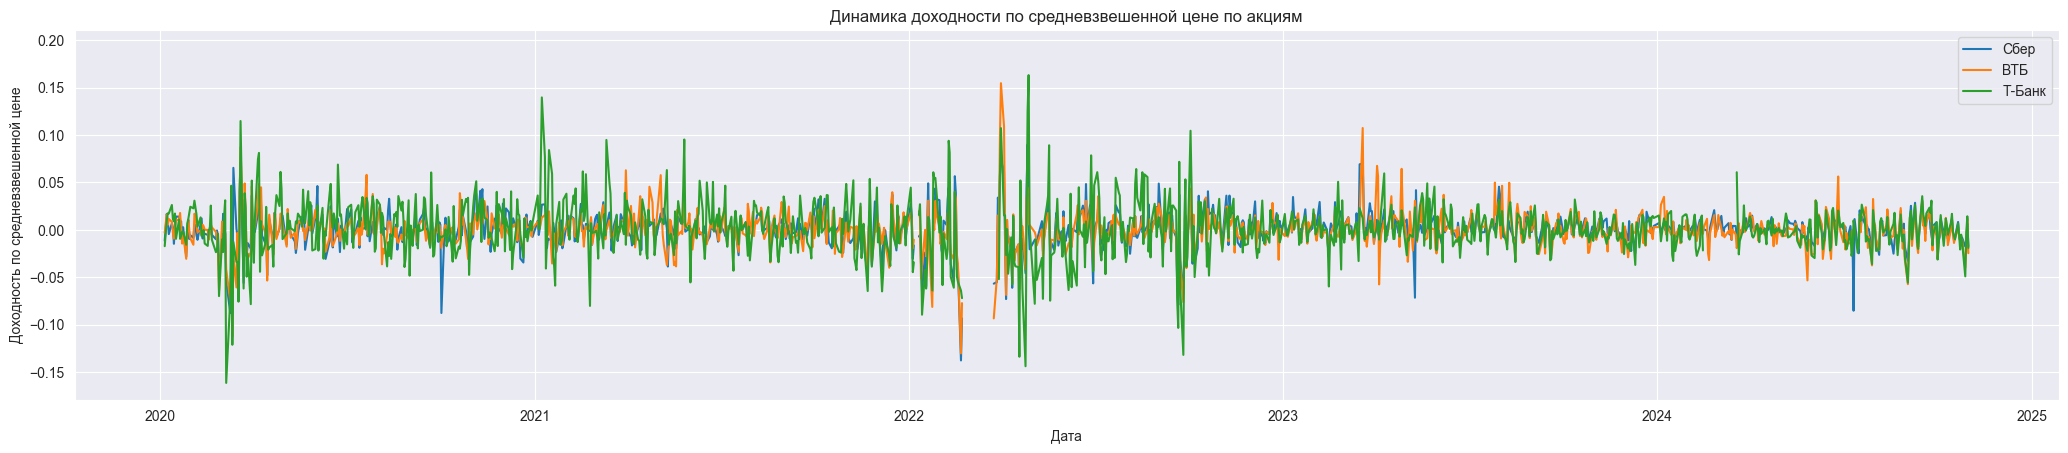

In [102]:
plt.figure(figsize=(25.6, 4.8))
for name in spbn:
    plt.plot(df_merged.index, df_merged[f"Доходность по средневзвешенной цене для {name}"], label=name)
plt.xlabel('Дата')
plt.ylabel('Доходность по средневзвешенной цене')
plt.title('Динамика доходности по средневзвешенной цене по акциям')
plt.legend()
plt.show()

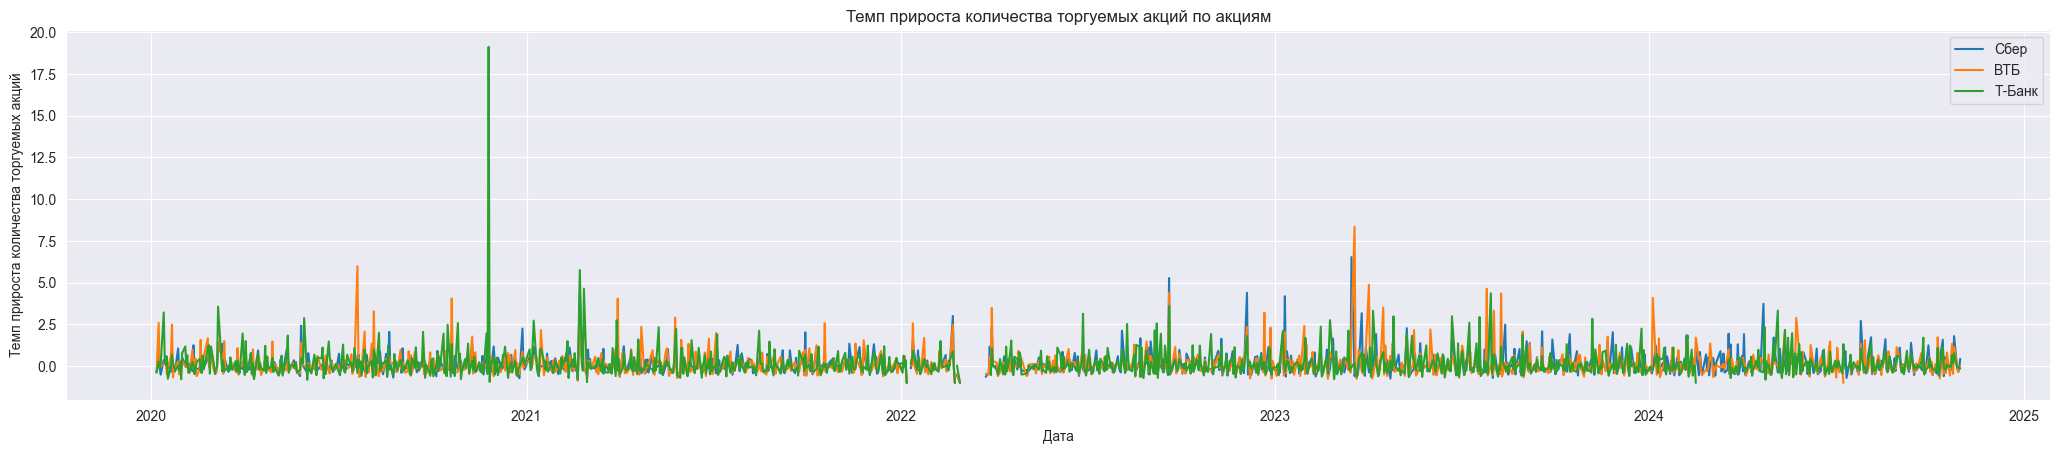

In [103]:
plt.figure(figsize=(25.6, 4.8))
for name in spbn:
    plt.plot(df_merged.index, df_merged[f"Темп прироста количества торгуемых акций для {name}"], label=name)
plt.xlabel('Дата')
plt.ylabel('Темп прироста количества торгуемых акций')
plt.title('Темп прироста количества торгуемых акций по акциям')
plt.legend()
plt.show()

### Проверим с помощью Z-тестирования гипотезу о том, что акции Сбера и Т-Банка имеют в среднем равные доходности. Возьмем уровень значимости 0.05

In [104]:
r_sber_sr = dfsber['Доходность по средневзвешенной цене'].mean()
r_t_sr = dft['Доходность по средневзвешенной цене'].mean()
disp_sber = dfsber['Доходность по средневзвешенной цене'].var()
disp_t = dft['Доходность по средневзвешенной цене'].var()
num_sber = dfsber['Доходность по средневзвешенной цене'].count()
num_t = dft['Доходность по средневзвешенной цене'].count()
uz = 0.05
gran1 = uz / 2
gran2 = 1 - uz /2
zcrit1 = sts.norm.ppf(gran1)
zcrit2 = sts.norm.ppf(gran2)
chisl = r_sber_sr - r_t_sr
pod_kor = disp_sber / num_sber + disp_t / num_t
znam = pod_kor ** 0.5
z = chisl / znam
print(z)
print(zcrit1  <= z <= zcrit2)

-0.8409069384291616
True


Как видим, Z-статистика попадает в доверительный интервал при данном уровне значимости. Значит, различия в доходностях акций Сбера и Т-Банка не являются статистически значимыми, и значительного перевеса в доходностях акций одного банка над доходностью акций другого банка не наблюдается.

In [105]:
r_sber_sr = dfsber['Доходность по средневзвешенной цене'].mean()
r_vtb_sr = dfvtb['Доходность по средневзвешенной цене'].mean()
disp_sber = dfsber['Доходность по средневзвешенной цене'].var()
disp_vtb = dfvtb['Доходность по средневзвешенной цене'].var()
num_sber = dfsber['Доходность по средневзвешенной цене'].count()
num_vtb = dfvtb['Доходность по средневзвешенной цене'].count()
uz = 0.05
gran1 = uz / 2
gran2 = 1 - uz /2
zcrit1 = sts.norm.ppf(gran1)
zcrit2 = sts.norm.ppf(gran2)
chisl = r_sber_sr - r_vtb_sr
pod_kor = disp_sber / num_sber + disp_vtb / num_vtb
znam = pod_kor ** 0.5
z = chisl / znam
print(z)
print(zcrit1  <= z <= zcrit2)

1.0337492008148934
True


Как видим, Z-статистика попадает в доверительный интервал при данном уровне значимости. Значит, различия в доходностях акций Сбера и ВТБ не являются статистически значимыми, и значительного перевеса в доходностях акций одного банка над доходностью акций другого банка не наблюдается.

In [106]:
r_vtb_sr = dfvtb['Доходность по средневзвешенной цене'].mean()
r_t_sr = dft['Доходность по средневзвешенной цене'].mean()
disp_vtb = dfvtb['Доходность по средневзвешенной цене'].var()
disp_t = dft['Доходность по средневзвешенной цене'].var()
num_vtb = dfvtb['Доходность по средневзвешенной цене'].count()
num_t = dft['Доходность по средневзвешенной цене'].count()
uz = 0.05
gran1 = uz / 2
gran2 = 1 - uz /2
zcrit1 = sts.norm.ppf(gran1)
zcrit2 = sts.norm.ppf(gran2)
chisl = r_vtb_sr - r_t_sr
pod_kor = disp_vtb / num_vtb + disp_t / num_t
znam = pod_kor ** 0.5
z = chisl / znam
print(z)
print(zcrit1  <= z <= zcrit2)

-1.6181932478171068
True


Как видим, Z-статистика попадает в доверительный интервал при данном уровне значимости. Значит, различия в доходностях акций Т-Банка и ВТБ не являются статистически значимыми, и значительного перевеса в доходностях акций одного банка над доходностью акций другого банка не наблюдается.